In [1]:
import pandas as pd
import numpy as np
from datetime import date
from tqdm.auto import tqdm
import seaborn as sns
from zipfile import ZipFile

import os
import re
import matplotlib.pyplot as plt

import sys
from pathlib import Path
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Loading and Managing Data

If the processed data files exists (for covered and all trials), it will read it, if not it will create it from the raw data. See files in the `lib` folder and function docstrings for details of functions. The GitHub will always contains the processed data files but interested users should also be able to re-create them from the raw data as needed. The process used to archive the raw data in our storage format is detailed here:
https://github.com/ebmdatalab/clinicaltrials-act-converter

The processed data is included in this repository in the `data` folder. The raw data is too large to easily store on GitHub so we load it in from Dropbox storage when needed. If the Dropbox link ever fails, you can also download a copy of the raw data from here:
https://doi.org/10.6084/m9.figshare.12789902

You can then unzip and import/run `get_data_local` instead of `get_data` on the CSV locally to get the processed dataset.

In [3]:
try:
    df = pd.read_csv(parent + '/data/applicable_trials_2021-01-18.csv')
    
    #This file is zipped for easier storage on GitHub.
    zip_file = ZipFile(parent + '/data/all_trials_2021-01-18.csv.zip')
    df2 = pd.read_csv(zip_file.open('all_trials_2021-01-18.csv'))
    del zip_file
    
except FileNotFoundError:
    old_fda = parent + '/data/fdaaa_regulatory_snapshot.csv'
    
    #This data is the full ClinicalTrials.gov dataset for 18 Jan 2021.
    #Due to size, this is not in our GitHub repo, but stored on Dropbox 
    #You should also be able to download the raw data using this URL
    path = 'https://www.dropbox.com/s/awlhqwjtkzp6t4b/clinicaltrials_raw_clincialtrials_json_2021-01-18.csv.zip?dl=1'

    from lib.data_functions import fda_reg, get_data

    fda_reg_dict = fda_reg(old_fda)
    lines = get_data(path, '2021-01-18')

    #headers is just the list of header names to save space here
    from lib.final_df import make_row, make_dataframe, headers

    #Just pACTs/ACTs
    df = make_dataframe(tqdm(lines), fda_reg_dict, headers, act_filter=True, scrape_date = date(2021,1,18))
    
    #Everything on CT.gov
    df2 = make_dataframe(tqdm(lines), fda_reg_dict, headers, act_filter=False, scrape_date = date(2021,1,18))
    
    #We won't need this anymore so deleting to save some memory
    del lines
    
    #Uncomment this to save as a csv as appropriate
    #df.to_csv(parent + '/data/applicable_trials_2021-01-18.csv', index=False)
    #df2.to_csv(parent + '/data/all_trials_2021-01-18.csv', index=False)

In [4]:
#creating the sponsor size variable for regressions

#Getting counts of each sponsor across all of ClinicalTrials.gov
#Making a single column and dummies
group = df2[['nct_id', 'sponsor']].groupby('sponsor', as_index = False).count()
group.columns = ['sponsor', 'sponsored_trials']
df = df.merge(group, how='left', on='sponsor')
df['sponsor_quartile'] = pd.Categorical(pd.qcut(df.sponsored_trials, 4, labels=False), ordered=True)
s_q_df = pd.get_dummies(df.sponsor_quartile, prefix='s_q')
df = df.join(s_q_df)

#renaming columns
quart_rename = {'s_q_0': 'quartile_1', 's_q_1': 'quartile_2',  
                's_q_2': 'quartile_3', 's_q_3': 'quartile_4'}
df.rename(columns=quart_rename, inplace=True)

#Checking the ranges
quartile_ranges = pd.qcut(df.sponsored_trials, 4)
print(quartile_ranges.unique())

#creating a count of sponsors for applicable trials for rankings
app_group = df[['nct_id', 'sponsor']].groupby('sponsor', as_index = False).count()
app_group.columns = ['sponsor', 'covered_trials']
df = df.merge(app_group, how='left', on='sponsor')

#This is grouped by mean because each "group" of a single sponsor contains the same number of trials
#Could easily just be .max() or .min() as well
covered_trials = df[['sponsor', 'covered_trials']].groupby(by='sponsor', as_index=False).mean()

[(221.0, 988.0], (12.0, 221.0], (988.0, 3342.0], (0.999, 12.0]]
Categories (4, interval[float64]): [(0.999, 12.0] < (12.0, 221.0] < (221.0, 988.0] < (988.0, 3342.0]]


In [5]:
#Check that the quartiles assigned correctly
df['sponsor_quartile'].unique()

[2, 1, 3, 0]
Categories (4, int64): [0 < 1 < 2 < 3]

In [6]:
#Creating regression variables for use throughout
df['ind_spon'] = np.where(df.sponsor_type == 'Industry', 1, 0)
df['drug_trial'] = np.where(df.intervention_types.str.contains('Drug'), 1, 0)
phase_cats = ['Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 'Phase 3', 'Phase 4', 'N/A']
df.phase.fillna('N/A', inplace=True)
df['phase_collapsed'] = np.where(df.phase.isin(phase_cats[0:2]), 'Early Phase', 
                                np.where(df.phase.isin(phase_cats[2:4]), 'Late Phase', "N/A"))
df['phase_var'] = pd.Categorical(df.phase_collapsed, ordered=True, 
                                 categories = ['Early Phase', 'Late Phase', 'N/A'])
df['phase_var'] = df['phase_var'].cat.codes.astype('category')
phase_df = pd.get_dummies(df.phase_var, prefix = 'phase_cat')

df = df.join(phase_df)

phase_rename = {'phase_cat_0': 'early_phase', 'phase_cat_1': 'late_phase', 'phase_cat_2': 'N/A'}

df.rename(columns=phase_rename, inplace=True)

#Making sure date columns are dates
date_cols = ['certificate_date', "certificate_date_qc", "certificate_posted_date", 'primary_completion_date', 'completion_date', 
             'available_completion_date', 'due_date', 'last_updated_date', 'last_verified_date', 'results_first_submitted_date', 
             'results_submitted_date_qc', 'results_first_posted_date',  'first_results_submission_any', 
             'study_first_submitted_date', 'study_submitted_date_qc', 'study_first_posted_date', 'start_date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [7]:
analysis_cols = ['act_flag', 'ind_spon', 'drug_trial', 'early_phase', 'late_phase', 'N/A', 
                 'quartile_1', 'quartile_2', 'quartile_3', 'quartile_4']

In [8]:
#Importing functions created for analysis
from lib.analysis_functions import crosstab, simple_logistic_regression, create_ranking, get_count, get_prcts

# Overall Cohort Description

In [9]:
#Describing full data
total = len(df2)
all_applicable = len(df)
acts = df.act_flag.sum()
pacts = df.included_pact_flag.sum()
results_due = df.results_due.sum()
due_reported = len(df[(((df.has_results == 1) | (df.pending_results == 1)) & (df.results_due == 1))])
results_all = df.has_results.sum() + df.pending_results.sum()
df['reported_late'] = np.where(((df.results_due == 1) & (df.due_date < df.first_results_submission_any) & 
                                df.first_results_submission_any.notnull()), 1, 0)
df['compliant_reported'] = np.where((df.results_due == 1) & (df.reported_late == 0) & ((df.has_results == 1) | (df.pending_results == 1)), 1, 0)
late_results = df.reported_late.sum()


print(
    f'''As of 18 January 2021, there are {total} trials and
{all_applicable} publicly identifiable applicable trials covered by the law.
{acts} ({round(acts/all_applicable * 100,1)}%) of these are identifiable as ACTs 
and {pacts} ({round(pacts/all_applicable * 100,1)}%) as pACTs.
{results_due} ({round(results_due/all_applicable * 100 ,1)}%) are due to report results.
{results_all} ({round(results_all/all_applicable * 100 ,1)}%) of the entire cohort 
and {due_reported} ({round(due_reported/results_due * 100 ,1)}%) of the due cohort have any results submitted.
{due_reported - late_results} ({round(((due_reported - late_results)/results_due) * 100, 1)}%) of the due trials submitted their results on time.    
    '''
)

As of 18 January 2021, there are 364122 trials and
27645 publicly identifiable applicable trials covered by the law.
18363 (66.4%) of these are identifiable as ACTs 
and 9282 (33.6%) as pACTs.
8863 (32.1%) are due to report results.
6584 (23.8%) of the entire cohort 
and 6099 (68.8%) of the due cohort have any results submitted.
3499 (39.5%) of the due trials submitted their results on time.    
    


In [10]:
#Run this function to get reporting compliance crosstabs for any variable of interest 
crosstab(df[df.results_due == 1], 'compliant_reported', 'act_flag')

compliant_reported,0,1,All
act_flag,,,
0,3235,2249,5484
1,2129,1250,3379
All,5364,3499,8863


In [11]:
#Values for Table 1

summary = {}

for a in analysis_cols:
    cross = crosstab(df[df.results_due == 1], 'compliant_reported', a)
    summary[a] = get_prcts(cross)
    
pd.DataFrame(summary).T

,total,total_var,prct_total,n_comp,prct_comp
act_flag,8863.0,3379.0,38.1,1250.0,37.0
ind_spon,8863.0,3951.0,44.6,1784.0,45.2
drug_trial,8863.0,6096.0,68.8,2632.0,43.2
early_phase,8863.0,3487.0,39.3,1456.0,41.8
late_phase,8863.0,1770.0,20.0,869.0,49.1
N/A,8863.0,3606.0,40.7,1174.0,32.6
quartile_1,8863.0,2357.0,26.6,458.0,19.4
quartile_2,8863.0,2390.0,27.0,709.0,29.7
quartile_3,8863.0,2102.0,23.7,993.0,47.2
quartile_4,8863.0,2014.0,22.7,1339.0,66.5


In [12]:
#use this function to get the counts of values for any variable in the dataset
#Can use this on any study population throughout the analysis

#Example
get_count(df, 'sponsor_quartile')

,nct_id
sponsor_quartile,
0,7128
1,6710
2,6955
3,6852


## **Note:** 

**The below analyses contain some additional descriptive data for each area (e.g., additional figures, sponsor-level compliance information) not included in the published work due to space limits of the format. This remains in the notebook for any interested parties and to support N. DeVito's doctoral thesis which may draw on this data.**

# Registration - Prospective and >21 Days Late

The FDAAA 2007 requires that all covered trials are registered within 21 days of their start date, that is the date in which the first participant is enrolled in the study.

In [13]:
#Getting the fields we need
pr_cats = ['nct_id', 'act_flag', 'included_pact_flag', 'start_date', 'study_first_submitted_date', 
           'study_submitted_date_qc', 'study_first_posted_date', 'available_completion_date', 'sponsor', 
           'ind_spon', 'drug_trial', 'phase_var', 'early_phase', 'late_phase', 'N/A', 'quartile_1', 'quartile_2', 
           'quartile_3', 'quartile_4']

pr_df = df[pr_cats].reset_index(drop=True)

In [14]:
#this accounts for when the reg requirement came fully into effect as of Sept 27, 2008
pr_df['start_date_mod'] = np.where(pr_df.start_date < pd.Timestamp(2008,9,27), pd.Timestamp(2008,9,27) - pd.DateOffset(days=21),
                                   pr_df.start_date.dt.date)

#filter to check for trials registered within 21 days of the start date
legal_check = pr_df.study_first_submitted_date > (pr_df.start_date_mod + pd.DateOffset(days=21))
#1 means it was registered within the legal limit, 0 means in violation
pr_df['legal_reg'] = np.where(legal_check, 0, 1)

#filter to check for registration before the start date
pros_check = pr_df.study_first_submitted_date > pr_df.start_date
#1 means prospectively registered, 0 means retrospectively
pr_df['pros_reg'] = np.where(pros_check, 0, 1)

In [15]:
print('{} trials out of {} ({}%) covered trials were registered on time the legal definition'.format(
    len(pr_df[pr_df.legal_reg == 1]), len(pr_df), round(len(pr_df[pr_df.legal_reg == 1])/len(pr_df) * 100,2)))

print('{} trials out of {} ({}%) covered trials were registered prospectively'.format(
    len(pr_df[pr_df.pros_reg == 1]), len(pr_df), round(len(pr_df[pr_df.pros_reg == 1])/len(pr_df) * 100,2)))

24429 trials out of 27645 (88.37%) covered trials were registered on time the legal definition
22122 trials out of 27645 (80.02%) covered trials were registered prospectively


In [16]:
#calculating days late to register by the legal standard

legally_late = pr_df[pr_df.legal_reg == 0].reset_index(drop=True)
legally_late['days_late'] = (legally_late.study_first_submitted_date - (legally_late.start_date_mod + pd.DateOffset(days=21))) / pd.Timedelta('1 day')

In [17]:
#Getting legal registration status by ACT/pACT status
act_late = crosstab(pr_df, 'legal_reg','act_flag')
act_late

legal_reg,0,1,All
act_flag,,,
0,1464,7818,9282
1,1752,16611,18363
All,3216,24429,27645


In [18]:
#Percent of ACTs and pACTs registered late
late_pacts = round((act_late.iloc[0, :][0] / (act_late.iloc[0, :][0] + act_late.iloc[0, :][1])) * 100,1)
print(f"{late_pacts}% of pACTs were registered late")

late_acts = round((act_late.iloc[1, :][0] / (act_late.iloc[1, :][0] + act_late.iloc[1, :][1])) * 100,1)
print(f"{late_acts}% of ACTs were registered late")

15.8% of pACTs were registered late
9.5% of ACTs were registered late


In [19]:
#Descriptive statistics for days late
legally_late['days_late'].describe()

count    3216.000000
mean      296.153607
std       463.320311
min         1.000000
25%        28.000000
50%       111.000000
75%       354.000000
max      4239.000000
Name: days_late, dtype: float64

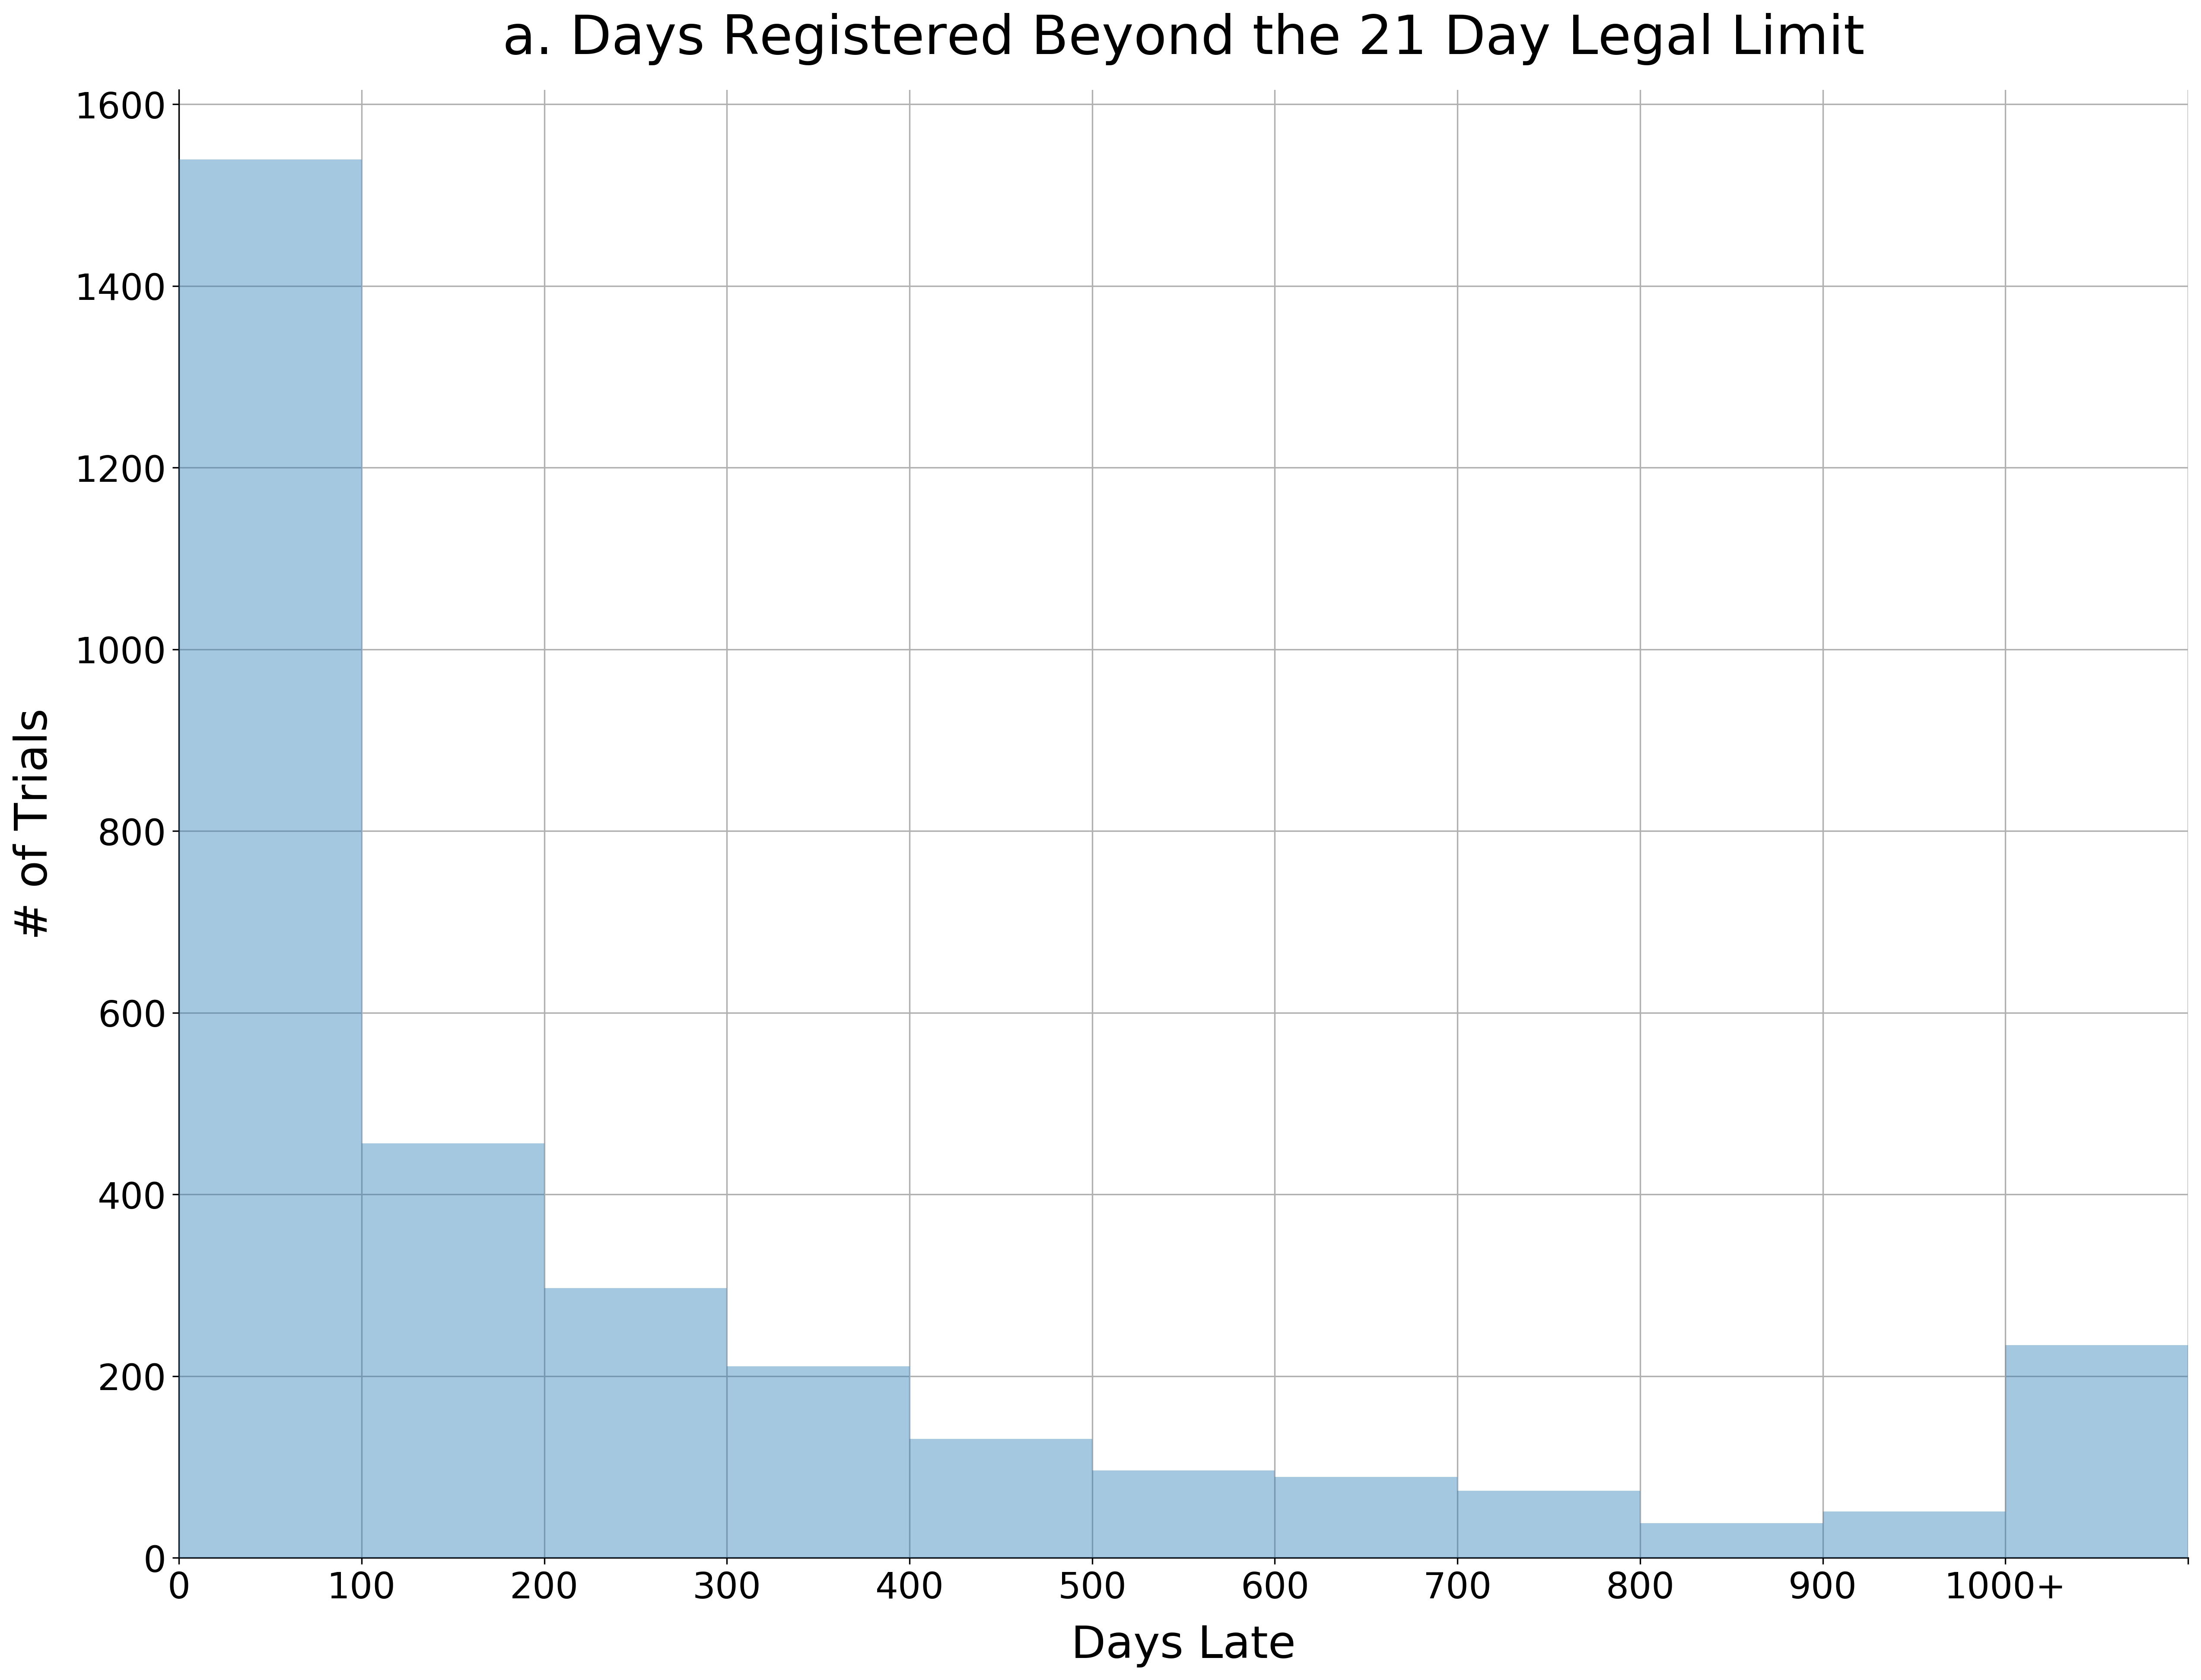

In [20]:
reg_bins = np.arange(0,1100 + 1, 100)
xlabels = ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000+']

fig, ax = plt.subplots(figsize=(20, 15), dpi=300)
ax.set_axisbelow(True)
ax.grid(zorder=0)
sns.distplot(np.clip(legally_late['days_late'],0,1000), hist=True, kde=False, bins=reg_bins, ax=ax,
             hist_kws = {'zorder':10}).set(xlim=(0,1100))
plt.xticks(reg_bins)
ax.set_xticklabels(xlabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('# of Trials', fontsize=25, labelpad=10)
plt.xlabel('Days Late', fontsize=25, labelpad=10)
plt.title("a. Days Registered Beyond the 21 Day Legal Limit", pad = 20, fontsize = 30)
plt.show()
#plt.savefig('figures/late_registration_1a.svg')

In [21]:
#Can use this function to get crosstabs for covariate of interest
crosstab(pr_df, 'legal_reg','act_flag')

legal_reg,0,1,All
act_flag,,,
0,1464,7818,9282
1,1752,16611,18363
All,3216,24429,27645


In [22]:
#Values for Table 1

summary = {}

for a in analysis_cols:
    cross = crosstab(pr_df, 'legal_reg', a)
    summary[a] = get_prcts(cross)
    
pd.DataFrame(summary).T

,total,total_var,prct_total,n_comp,prct_comp
act_flag,27645.0,18363.0,66.4,16611.0,90.5
ind_spon,27645.0,11444.0,41.4,10516.0,91.9
drug_trial,27645.0,19074.0,69.0,17358.0,91.0
early_phase,27645.0,12415.0,44.9,11533.0,92.9
late_phase,27645.0,5513.0,19.9,5102.0,92.5
N/A,27645.0,9717.0,35.1,7794.0,80.2
quartile_1,27645.0,7128.0,25.8,6135.0,86.1
quartile_2,27645.0,6710.0,24.3,5759.0,85.8
quartile_3,27645.0,6955.0,25.2,6153.0,88.5
quartile_4,27645.0,6852.0,24.8,6382.0,93.1


In [23]:
x_reg = pr_df[['act_flag', 'ind_spon', 'drug_trial', 'late_phase', 'N/A', 
               'quartile_2', 'quartile_3', 'quartile_4']].reset_index(drop=True)
y_reg = pr_df['legal_reg'].reset_index(drop=True)

In [24]:
#Use this cell to check crude regression analysis of interest:

crude_x = pr_df[['quartile_2', 'quartile_3', 'quartile_4']].reset_index(drop=True)

simple_logistic_regression(y_reg,crude_x,cis=.001)

Optimization terminated successfully.
         Current function value: 0.355040
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              legal_reg   No. Observations:                27645
Model:                          Logit   Df Residuals:                    27641
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                 0.01255
Time:                        22:08:53   Log-Likelihood:                -9815.1
converged:                       True   LL-Null:                       -9939.8
Covariance Type:            nonrobust   LLR p-value:                 8.422e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
quartile_2    -0.0200      0.049     -0.409      0.682      -0.116       0.076
quartile_3     0.2166      0.

,OR,0.05%,99.95%,p_value
quartile_2,0.98,0.83,1.15,0.68235
quartile_3,1.24,1.05,1.47,0.00002
quartile_4,2.20,1.81,2.67,0.00000
cons,6.18,5.52,6.91,0.00000


In [25]:
#Adjusted model for legal registration

conf = simple_logistic_regression(y_reg,x_reg,cis=.001)
conf

Optimization terminated successfully.
         Current function value: 0.328425
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              legal_reg   No. Observations:                27645
Model:                          Logit   Df Residuals:                    27636
Method:                           MLE   Df Model:                            8
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                 0.08657
Time:                        22:08:54   Log-Likelihood:                -9079.3
converged:                       True   LL-Null:                       -9939.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
act_flag       0.7586      0.040     18.967      0.000       0.680       0.837
ind_spon       0.7075      0.

,OR,0.05%,99.95%,p_value
act_flag,2.14,1.87,2.44,0.00000
ind_spon,2.03,1.74,2.37,0.00000
drug_trial,1.35,1.16,1.57,0.00000
late_phase,0.80,0.65,0.99,0.00052
N/A,0.38,0.32,0.44,0.00000
quartile_2,1.04,0.88,1.23,0.47996
quartile_3,1.76,1.47,2.11,0.00000
quartile_4,2.74,2.23,3.36,0.00000
cons,3.51,2.80,4.41,0.00000


In [138]:
#Here we are measuring late registrations so set the "legal_reg" markerer to 0

reg_rank = create_ranking(pr_df, 'legal_reg', marker=0)
#r_top_10_prct = reg_rank.legal_reg.quantile(.95)
reg_rank_merge = reg_rank.merge(covered_trials, on='sponsor')
reg_rank_merge['prct'] = round((reg_rank_merge['legal_reg'] / reg_rank_merge['covered_trials']) * 100,2)

#Check beyond top 10 to make sure no ties
reg_rank_merge[reg_rank_merge.covered_trials >= 50].sort_values(by='prct', ascending=False).head(11)

,sponsor,legal_reg,covered_trials,prct
16,"University of California, Davis",20,55,36.36
19,Southwest Oncology Group,18,52,34.62
5,Icahn School of Medicine at Mount Sinai,31,101,30.69
29,Ohio State University,15,50,30.00
10,Indiana University,24,97,24.74
22,"Children's Hospital Medical Center, Cincinnati",16,67,23.88
41,Northwell Health,12,54,22.22
18,"University of California, Los Angeles",19,87,21.84
45,The University of Texas Health Science Center ...,11,51,21.57
11,Columbia University,24,112,21.43


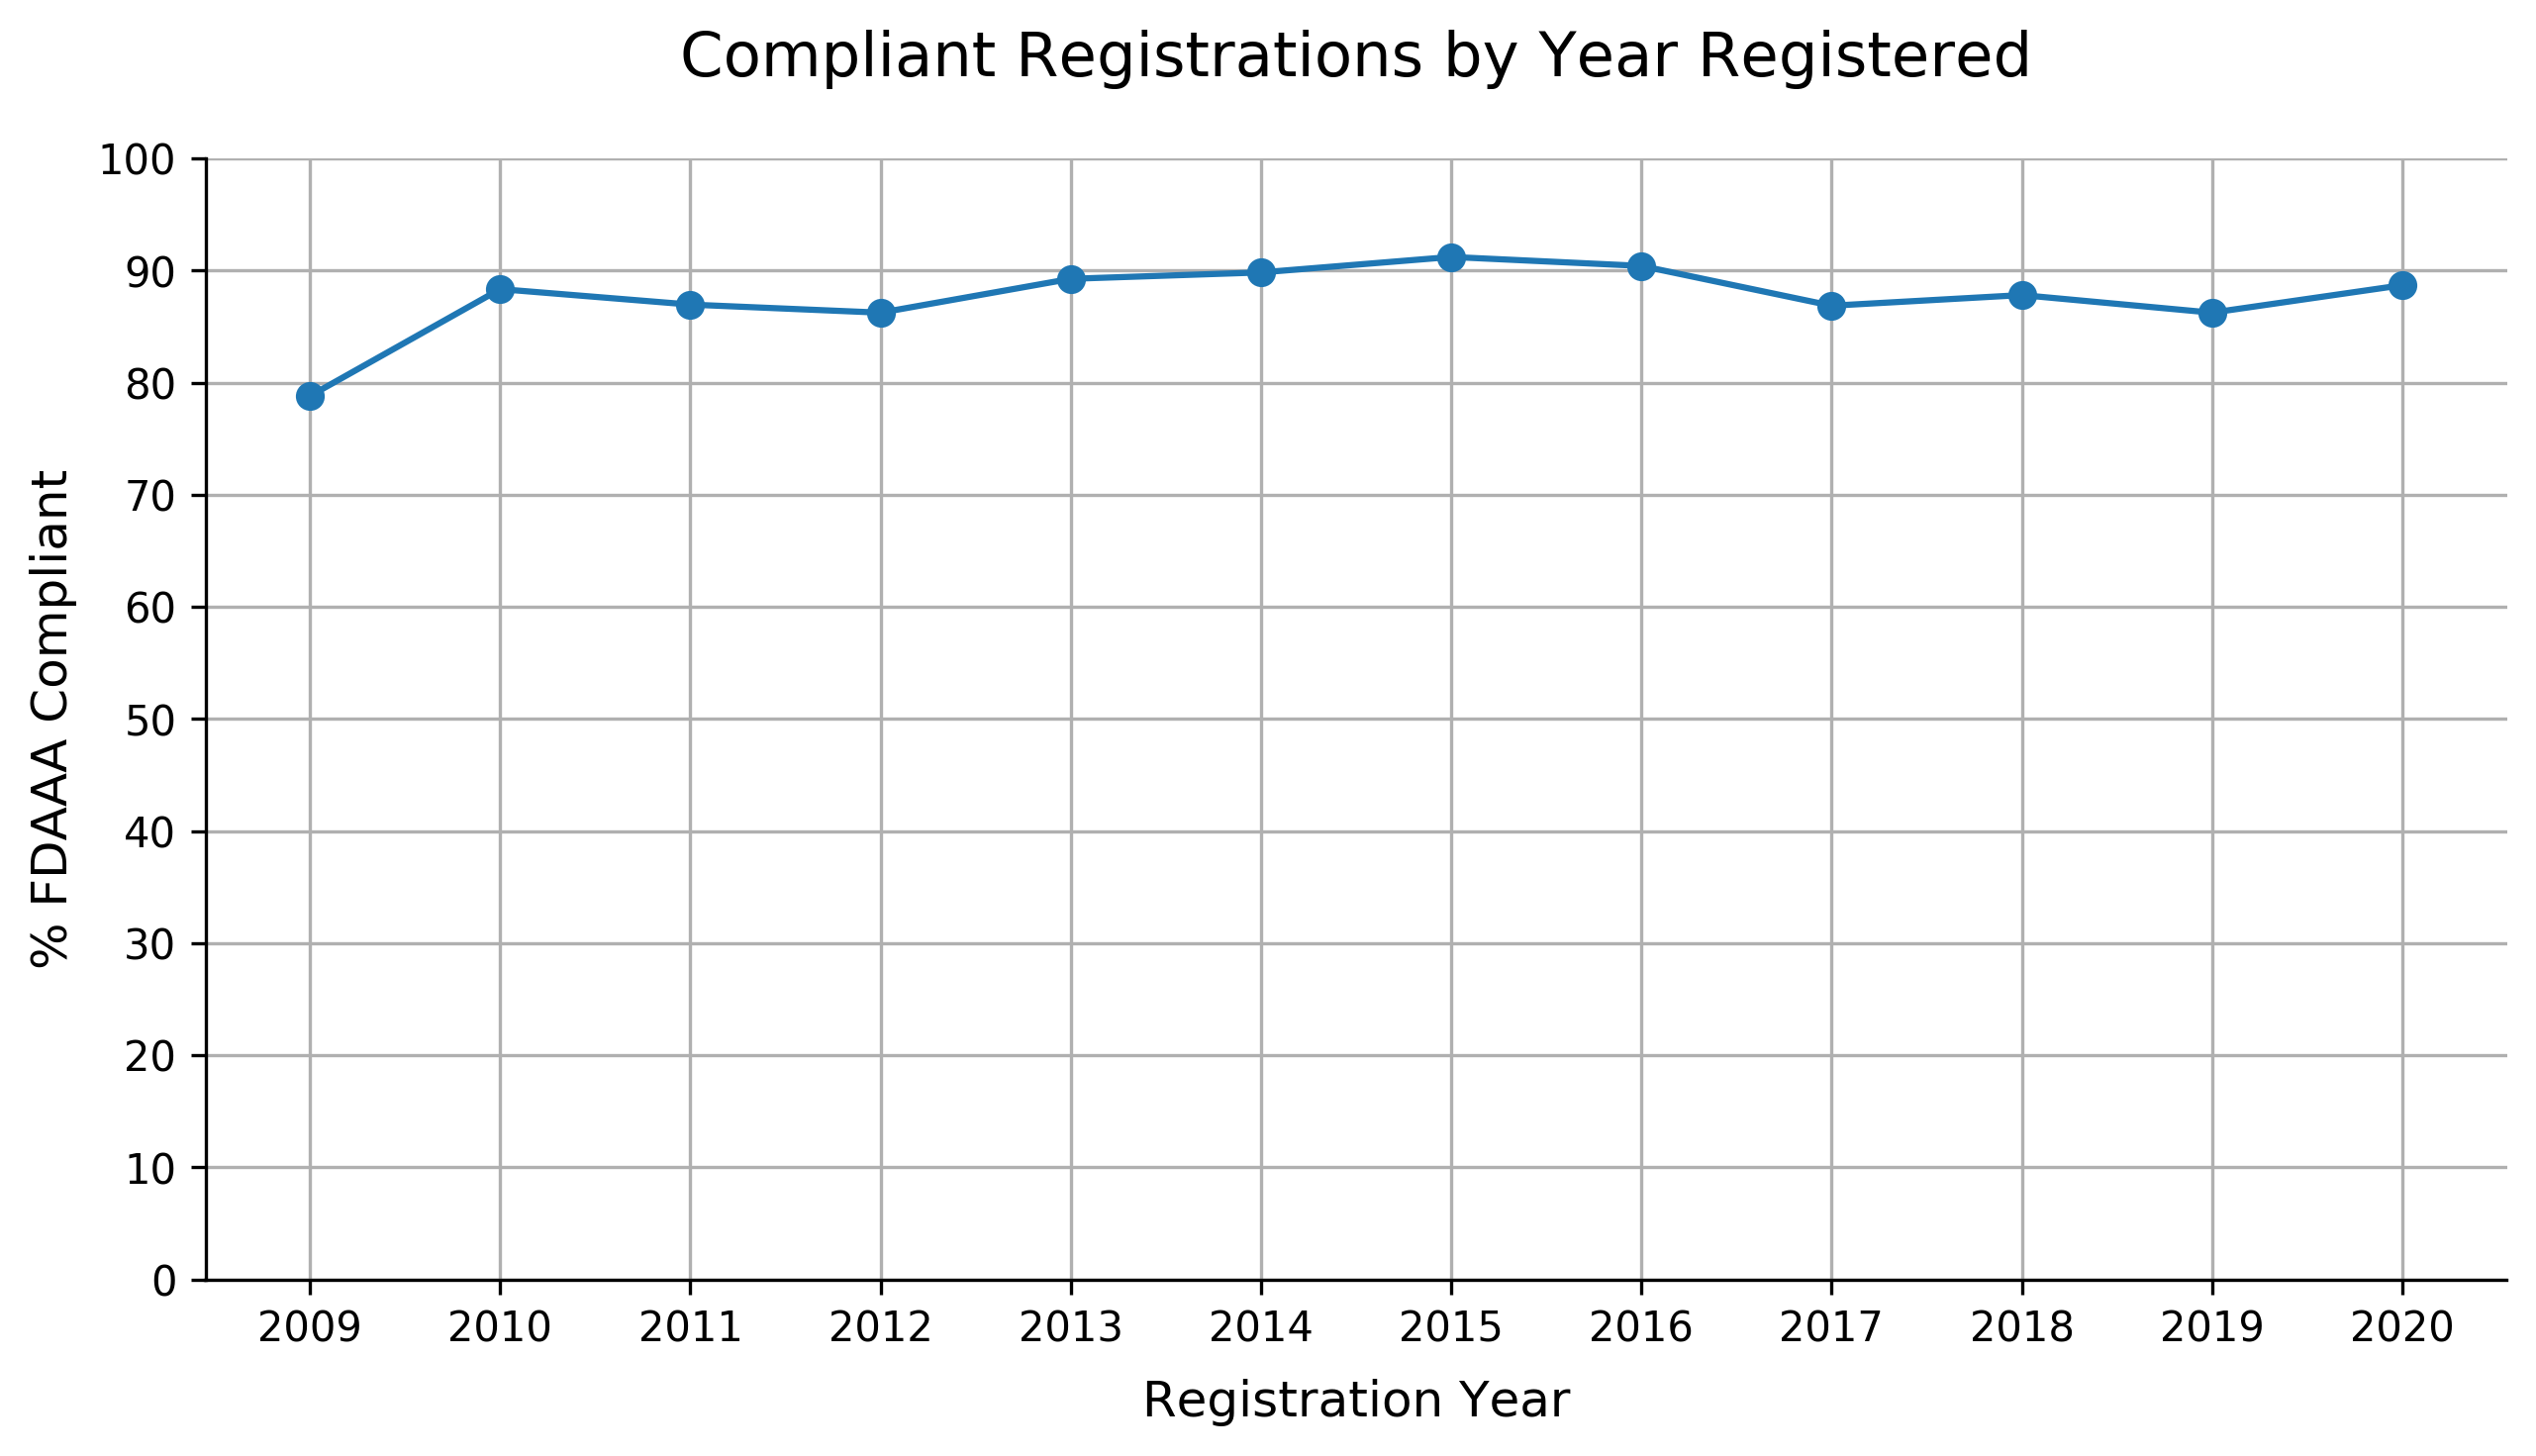

In [27]:
comp_by_year = pr_df[['study_first_submitted_date', 'legal_reg']].groupby(pr_df.study_first_submitted_date.dt.year).agg(['sum', 'count'])

comp_by_year['prct_comp'] = round((comp_by_year['legal_reg']['sum'] / comp_by_year['legal_reg']['count']) * 100,2)

reg_trends = comp_by_year[(comp_by_year.index >= 2009) & (comp_by_year.index <= 2020)]['prct_comp']

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
plt.plot(reg_trends, marker='o')
plt.xticks(reg_trends.index)
plt.yticks(range(0,101,10))
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('% FDAAA Compliant', fontsize=12, labelpad=5)
plt.xlabel('Registration Year', fontsize=12, labelpad=7)
plt.title("Compliant Registrations by Year Registered", pad = 20, fontsize = 15)
plt.show()
#plt.savefig('figures/reg_trends.svg')

# Last Verified Date

The Final Rule states that all covered trials are required to verify their data once a year. Here we examine how many trials, registered for more than a year, had verified within the last calendar year.

In [28]:
cols = ['nct_id', 'has_results', 'pending_results', 'primary_completion_date', 'completion_date', 'study_first_posted_date', 
        'last_verified_date', 'last_updated_date', 'sponsor', 'act_flag', 'ind_spon', 'drug_trial', 'phase_var', 
        'early_phase', 'late_phase', 'N/A', 'quartile_1', 'quartile_2', 'quartile_3', 'quartile_4']
update_dataset = df[cols].reset_index(drop=True)

update_dataset['scrape_date'] = date(2021,1,18)

In [29]:
#Logic for exclusion
print('We start with all applicable trials: {}'.format(len(df)))

#We exclude trials that were first posted to ClinicalTrials.gov within the last year 
#as they don't have a full year of follow-up
exclude_under_a_year = update_dataset.study_first_posted_date >= pd.Timestamp(2020,1,18)
print("Exclude {} for starting within the last year (since 18 Jan 2020)".format(len(update_dataset[exclude_under_a_year])))
new_excluded = update_dataset[~exclude_under_a_year].reset_index(drop=True)
print("{} remaining".format(len(new_excluded)))

#We then exclude trials that have reached full completion as of the scrape date and have posted results.
#The law frees you from your responsibility to verify once a year when you have posted all results following
#completion of the trial
complete_results = (new_excluded.completion_date < new_excluded.scrape_date) & (new_excluded.has_results == 1)
print("Exclude {} for being completed with public results".format(len(new_excluded[complete_results])))
complete_excluded = new_excluded[~complete_results].reset_index(drop=True)
print("{} remaining".format(len(complete_excluded)))

#Lastly we exclude trials with pending results as these likely have a newer verification that will appear once the
#results complete QC review.
print("Eclude {} for being currently pending".format(len(complete_excluded[complete_excluded.pending_results==1])))
cohort = complete_excluded[complete_excluded.pending_results == 0].reset_index(drop=True)
print("{} remaining".format(len(cohort)))

We start with all applicable trials: 27645
Exclude 4819 for starting within the last year (since 18 Jan 2020)
22826 remaining
Exclude 5334 for being completed with public results
17492 remaining
Eclude 783 for being currently pending
16709 remaining


In [30]:
#Dummy for late verification
#Our data is from 18 Jan 2021 meaning verifications older than 18 January 2020 are officially out of date. 
#However, verifications are usually only provided in "Month Year" format with no date. As such, they are defaulted
#to the beginning of the month. Conservatively, we will treat 1 January 2019 as our cutoff.

# Late Verification = 0, Currently Verified = 1
cohort['comp_veri'] = np.where(cohort.last_verified_date >= pd.Timestamp(2020,1,1), 1,0)
cohort['late_veri'] = np.where(cohort.last_verified_date < pd.Timestamp(2020,1,1), 1,0)
late_veri = len(cohort[cohort.comp_veri == 0])
prct_late = round(cohort.late_veri.sum()/len(cohort)*100,1)
print('{} of {} ({}%) of eligible trials are overdue to verify their records'.format(len(cohort)-late_veri, len(cohort), 100-prct_late))   

12632 of 16709 (75.6%) of eligible trials are overdue to verify their records


In [31]:
#describing the days late for unverified trials

cohort['verification_due'] = cohort.last_verified_date + pd.DateOffset(years=1)
cohort['days_late'] = np.where(cohort.comp_veri == 0, (pd.Timestamp(2021,1,1) - cohort.verification_due) / pd.Timedelta('1 day'), 0)
cohort[cohort['comp_veri'] == 0].days_late.describe()

count    4077.000000
mean      383.948982
std       348.927853
min        23.000000
25%       122.000000
50%       275.000000
75%       550.000000
max      3775.000000
Name: days_late, dtype: float64

In [32]:
late_with_update = len(cohort[(cohort.comp_veri == 0) & (cohort.last_updated_date > pd.Timestamp(2020,1,18))])

print('{} trials with a late verification updated since 1 January 2019'.format(late_with_update))
print('This is {}% of the currently late trials'.format(round(late_with_update/late_veri * 100,2)))

308 trials with a late verification updated since 1 January 2019
This is 7.55% of the currently late trials


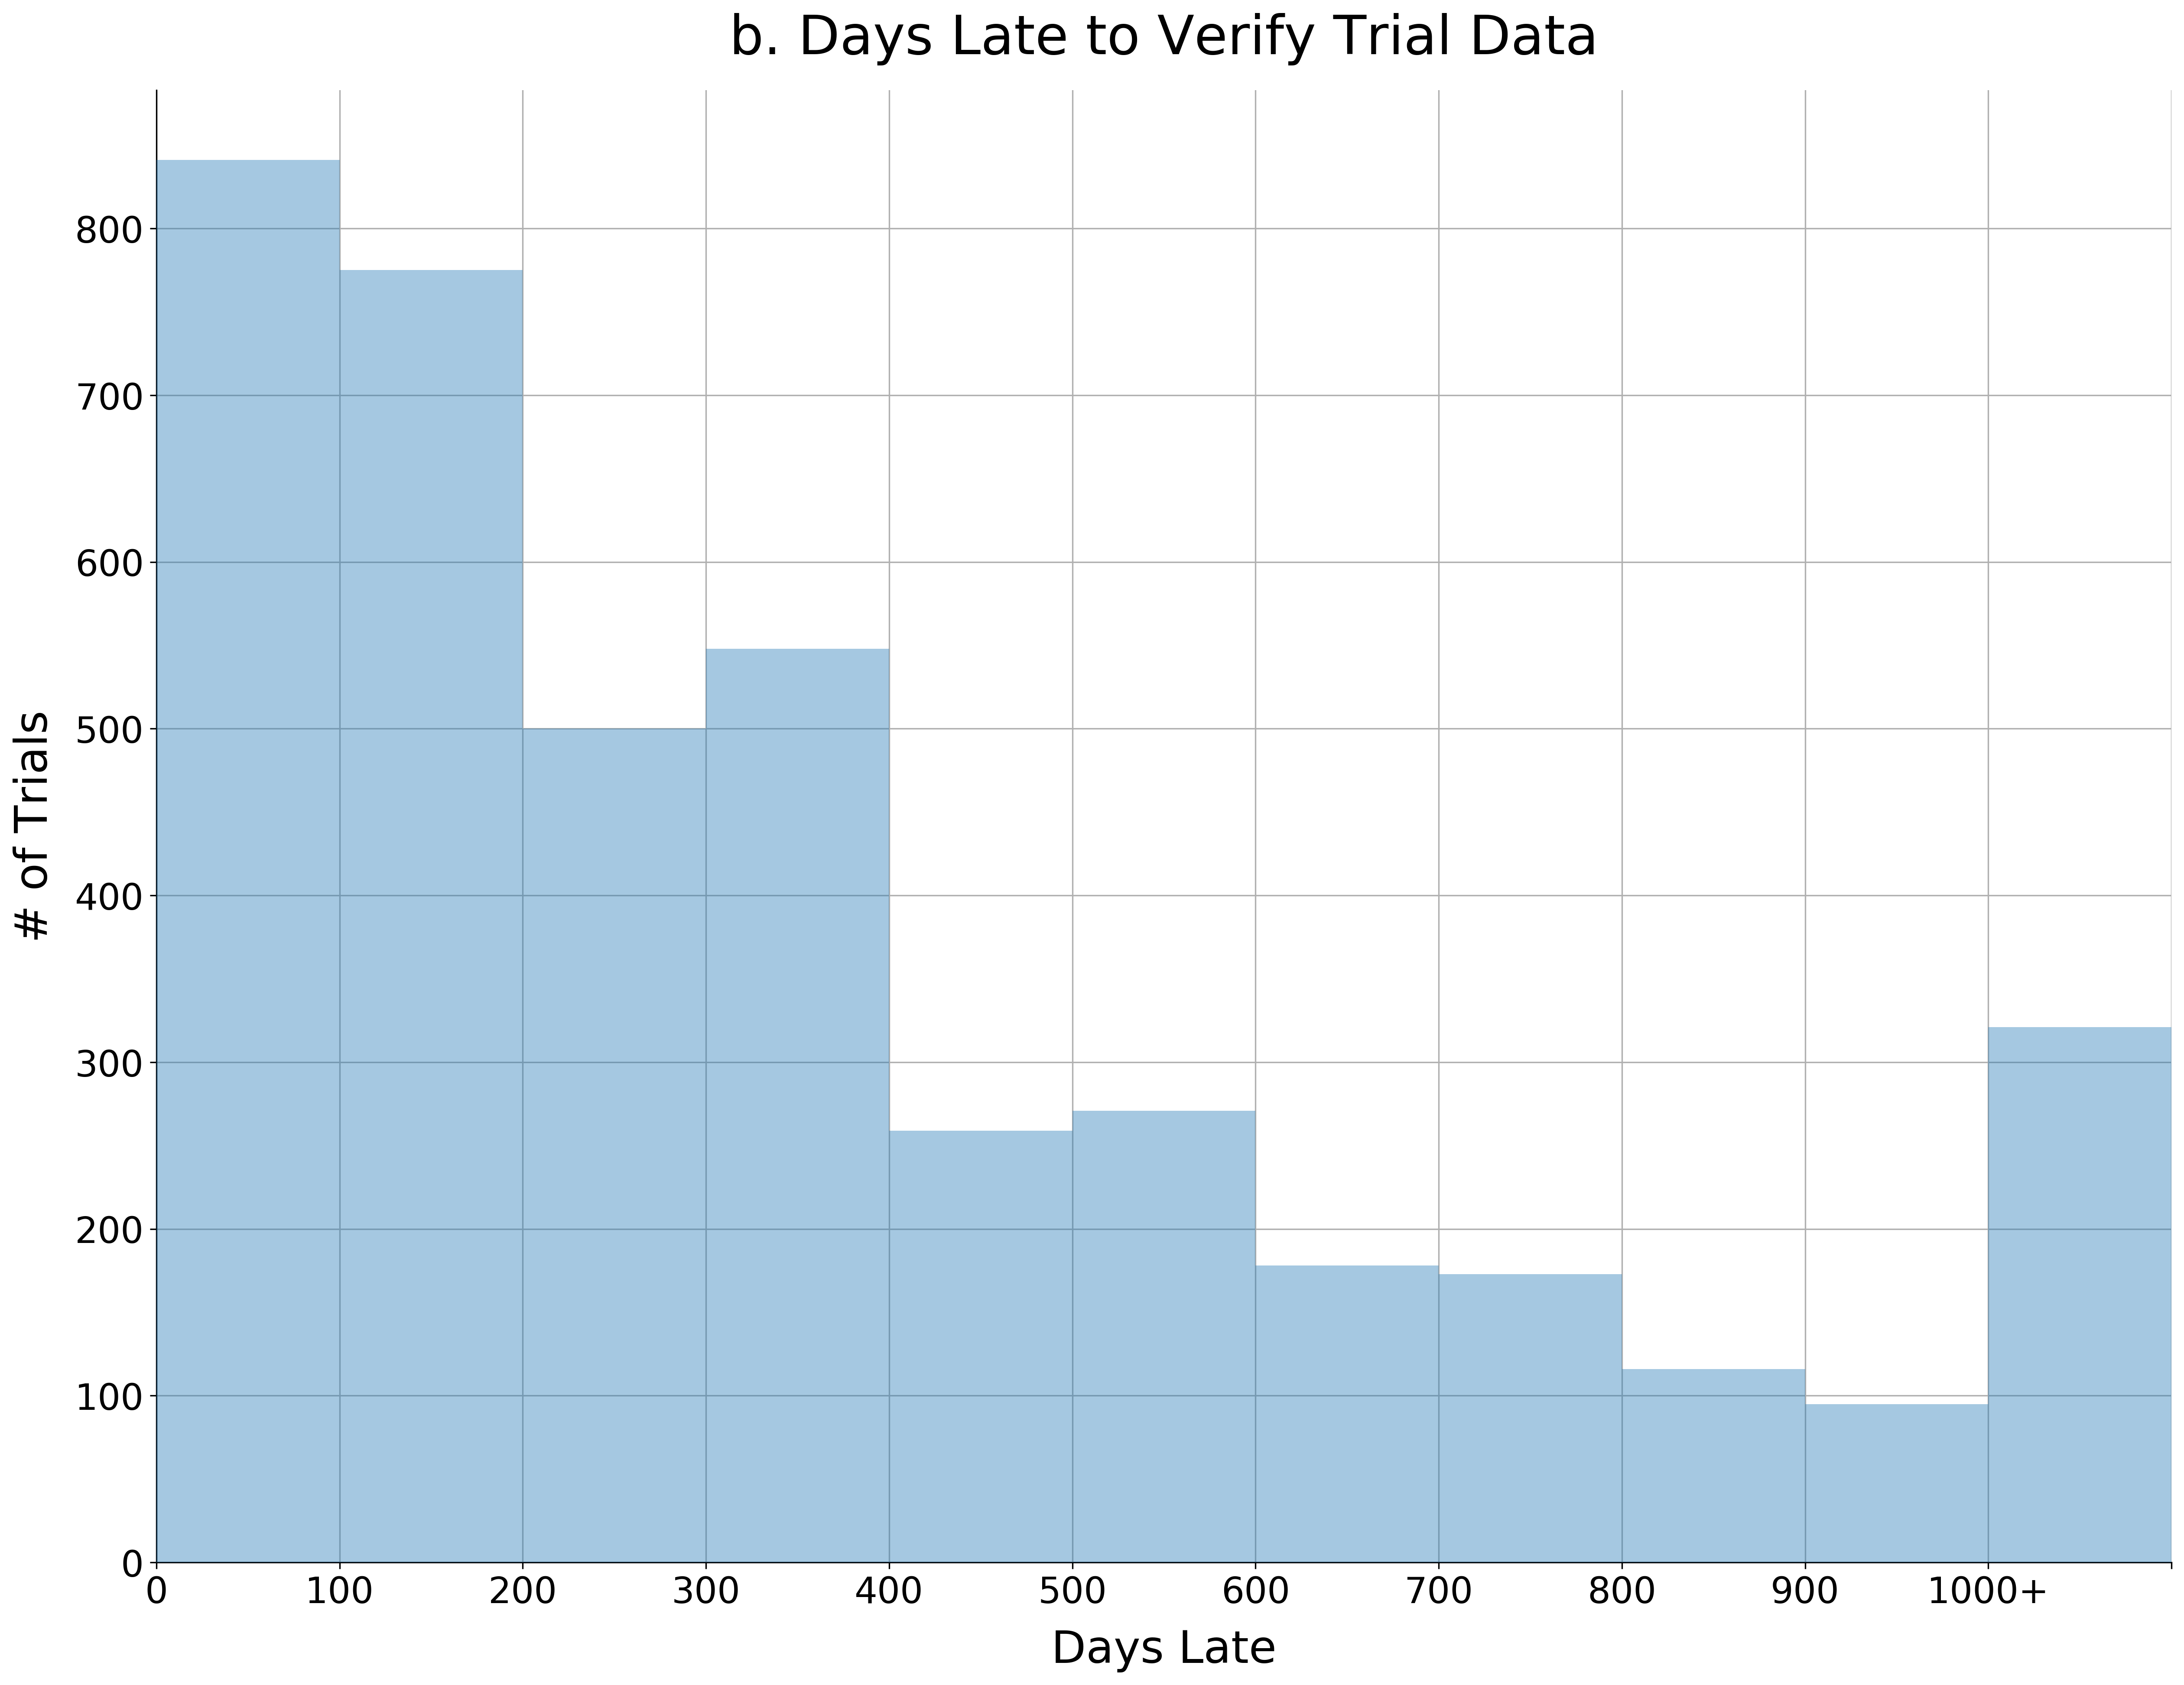

In [33]:
ver_bins = np.arange(0,1100 + 1, 100)
xlabels = ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000+']

fig, ax = plt.subplots(figsize=(20, 15), dpi=300)
ax.set_axisbelow(True)
ax.grid(zorder=0)
sns.distplot(np.clip(cohort[cohort['comp_veri'] == 0].days_late,0,1000), hist=True, kde=False, bins=ver_bins, ax=ax,
             hist_kws = {'zorder':10}).set(xlim=(0,1100))
plt.xticks(ver_bins)
ax.set_xticklabels(xlabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('# of Trials', fontsize=25, labelpad=10)
plt.xlabel('Days Late', fontsize=25, labelpad=10)
plt.title("b. Days Late to Verify Trial Data", pad = 20, fontsize = 30)
plt.show()
#plt.savefig('figures/last_verified_1b.svg')

In [34]:
#Can crosstab any variable here.
crosstab(cohort, 'comp_veri', 'act_flag')

comp_veri,0,1,All
act_flag,,,
0,1594,3586,5180
1,2483,9046,11529
All,4077,12632,16709


In [35]:
#For Table 1
summary = {}

for a in analysis_cols:
    cross = crosstab(cohort, 'comp_veri', a)
    summary[a] = get_prcts(cross)
    
pd.DataFrame(summary).T

,total,total_var,prct_total,n_comp,prct_comp
act_flag,16709.0,11529.0,69.0,9046.0,78.5
ind_spon,16709.0,6603.0,39.5,5001.0,75.7
drug_trial,16709.0,11492.0,68.8,9004.0,78.4
early_phase,16709.0,7802.0,46.7,6297.0,80.7
late_phase,16709.0,3247.0,19.4,2611.0,80.4
N/A,16709.0,5660.0,33.9,3724.0,65.8
quartile_1,16709.0,4526.0,27.1,2788.0,61.6
quartile_2,16709.0,4095.0,24.5,2747.0,67.1
quartile_3,16709.0,4128.0,24.7,3464.0,83.9
quartile_4,16709.0,3960.0,23.7,3633.0,91.7


In [36]:
y_veri = cohort.comp_veri
x_veri = cohort[['act_flag', 'ind_spon', 'drug_trial', 'late_phase', 'N/A', 'quartile_2', 
                 'quartile_3', 'quartile_4']].reset_index(drop=True)

In [37]:
#Use this cell for crude OR of interest by changeing the value of crude_x

crude_x = cohort[['late_phase', 'N/A']].reset_index(drop=True)

simple_logistic_regression(y_veri,crude_x,cis=.001)

Optimization terminated successfully.
         Current function value: 0.542705
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              comp_veri   No. Observations:                16709
Model:                          Logit   Df Residuals:                    16706
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                 0.02329
Time:                        22:09:04   Log-Likelihood:                -9068.1
converged:                       True   LL-Null:                       -9284.3
Covariance Type:            nonrobust   LLR p-value:                 1.210e-94
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
late_phase    -0.0190      0.053     -0.360      0.719      -0.122       0.084
N/A           -0.7771      0.

,OR,0.05%,99.95%,p_value
late_phase,0.98,0.82,1.17,0.71865
N/A,0.46,0.40,0.52,0.00000
cons,4.18,3.81,4.60,0.00000


In [38]:
#Outcome here is having a current verification date - adjusted

simple_logistic_regression(y_veri,x_veri, cis=.001)

Optimization terminated successfully.
         Current function value: 0.489115
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              comp_veri   No. Observations:                16709
Model:                          Logit   Df Residuals:                    16700
Method:                           MLE   Df Model:                            8
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                  0.1197
Time:                        22:09:04   Log-Likelihood:                -8172.6
converged:                       True   LL-Null:                       -9284.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
act_flag       0.6872      0.041     16.716      0.000       0.607       0.768
ind_spon       0.4184      0.

,OR,0.05%,99.95%,p_value
act_flag,1.99,1.74,2.28,0.00000
ind_spon,1.52,1.31,1.76,0.00000
drug_trial,0.94,0.80,1.10,0.20472
late_phase,0.92,0.77,1.11,0.15791
N/A,0.46,0.39,0.54,0.00000
quartile_2,1.36,1.17,1.59,0.00000
quartile_3,4.35,3.60,5.25,0.00000
quartile_4,8.70,6.92,10.93,0.00000
cons,1.08,0.86,1.35,0.24903


In [133]:
#Getting an overview of late verifications as a percent of all covered trials

veri_rank = create_ranking(cohort, 'late_veri')
#v_top_10_prct = veri_rank.late_veri.quantile(.95)
veri_rank_merge = veri_rank.merge(covered_trials, on='sponsor')
veri_rank_merge['prct'] = round((veri_rank_merge['late_veri'] / veri_rank_merge['covered_trials']) * 100,2)

veri_rank_merge[veri_rank_merge.covered_trials >= 50].sort_values(by='prct', ascending=False).head(11)

,sponsor,late_veri,covered_trials,prct
3,University of Southern California,34,78,43.59
4,University of Virginia,28,71,39.44
11,Ohio State University,19,50,38.00
7,City of Hope Medical Center,22,87,25.29
6,Columbia University,24,112,21.43
10,Brigham and Women's Hospital,20,104,19.23
15,"University of Maryland, Baltimore",15,80,18.75
9,University of Chicago,20,108,18.52
1,Massachusetts General Hospital,53,303,17.49
17,"University of California, Los Angeles",15,87,17.24


In [146]:
#And here we restrict it to only the percent of those in the population that could have a late verification

only_veri_cohort = cohort[['sponsor', 'late_veri']].groupby('sponsor', as_index=False)['late_veri'].agg(['sum','count'])
only_veri_cohort['prct'] = round((only_veri_cohort['sum'] / only_veri_cohort['count']) * 100,2)
merged_veri = only_veri_cohort.merge(covered_trials, on='sponsor')
merged_veri[merged_veri.covered_trials >= 50].sort_values(by='prct', ascending=False).head(11)

,sponsor,sum,count,prct,covered_trials
4092,University of Southern California,34,55,61.82,78
4108,University of Virginia,28,48,58.33,71
2856,Ohio State University,19,33,57.58,50
921,Columbia University,24,58,41.38,112
2907,Oregon Health and Science University,9,22,40.91,53
882,City of Hope Medical Center,22,64,34.38,87
631,Brigham and Women's Hospital,20,63,31.75,104
2330,Massachusetts General Hospital,53,173,30.64,303
4029,"University of California, Los Angeles",15,52,28.85,87
4033,University of Chicago,20,71,28.17,108


In [125]:
only_veri_cohort.sort_values(by='sum', ascending=False).head(11)

,sum,count,prct
sponsor,,,
M.D. Anderson Cancer Center,73,434,16.82
Massachusetts General Hospital,53,173,30.64
Stanford University,36,131,27.48
University of Southern California,34,55,61.82
University of Virginia,28,48,58.33
Henry Ford Health System,24,31,77.42
Columbia University,24,58,41.38
Cairo University,22,27,81.48
City of Hope Medical Center,22,64,34.38


# Certificate Analysis

Sponsors of trials covered under FDAAA can seek delays to the deadline to seek results under certain circumstances. The Final Rule specified that these certificates must be requested prior to when the results would otherwise become does (i.e., a year from primary completion).

In [40]:
cert_analysis = df[['nct_id','due_date', 'has_results', 'has_certificate', "certificate_date_qc", "certificate_posted_date",
                    'certificate_date', 'late_cert', 'results_submitted_date_qc', 'sponsor', 'act_flag', 'ind_spon', 'drug_trial', 
                    'phase_var', 'early_phase', 'late_phase', 'N/A', 'quartile_1', 'quartile_2', 'quartile_3', 
                    'quartile_4']].reset_index(drop=True)

#all_trials = df[['nct_id', 'due_date', 'results_due', 'has_certificate']].reset_index(drop=True)
#all_trials['due_date'] = pd.to_datetime(all_trials.due_date)

In [41]:
certificate = cert_analysis[cert_analysis.has_certificate == 1].reset_index(drop=True)
all_certificates = certificate.nct_id.count()
late_certificates = certificate.late_cert.sum()
certificate['on_time_cert'] = np.where(certificate.late_cert==1, 0, 1)
certs_with_results = certificate.has_results[certificate.has_results == 1].sum()
late_certs_with_results = certificate.has_results[(certificate.has_results == 1) & (certificate.late_cert == 1)].sum()

In [42]:
print('As of 18 Jan 2021, {} ({}%) trials had recieved Certificates of Delay out of {} applicable trials'
      .format(all_certificates, round(all_certificates/len(df) * 100, 2), len(df)))
print('{} of those {} ({}%) have results'
      .format(certs_with_results, all_certificates, round(certs_with_results/all_certificates * 100,2)))
print('{} of certificates were submitted late. That is {}% of all certificates'
      .format(late_certificates, round((late_certificates/all_certificates)*100)))
print('Of those submitted late, only {} have since posted any results, {}% of all late certificates'
      .format(late_certs_with_results, round(late_certs_with_results/late_certificates * 100,2)))

As of 18 Jan 2021, 1354 (4.9%) trials had recieved Certificates of Delay out of 27645 applicable trials
541 of those 1354 (39.96%) have results
461 of certificates were submitted late. That is 34.0% of all certificates
Of those submitted late, only 141 have since posted any results, 30.59% of all late certificates


In [43]:
#certificate['due_date'] = pd.to_datetime(certificate.due_date)
#certificate['certificate_date'] = pd.to_datetime(certificate.certificate_date)
#certificate['results_submitted_date_qc'] = pd.to_datetime(certificate.results_submitted_date_qc)
certificate['scrape_date'] = pd.Timestamp(2021,1,18)
certificate['days_late'] = certificate.certificate_date - certificate.due_date
days_late_count = certificate.days_late[certificate.late_cert == 1] / pd.Timedelta(days=1)

In [44]:
days_late_count.describe()

count    461.000000
mean     122.724512
std      142.564463
min        1.000000
25%       22.000000
50%       72.000000
75%      174.000000
max      884.000000
Name: days_late, dtype: float64

In [45]:
print(f"{len(days_late_count[days_late_count > 100])} of {len(days_late_count)} trials with a \
late certificate were more than 100 days late to apply. That is \
{round((len(days_late_count[days_late_count > 100])/len(days_late_count))*100,1)}%")

191 of 461 trials with a late certificate were more than 100 days late to apply. That is 41.4%


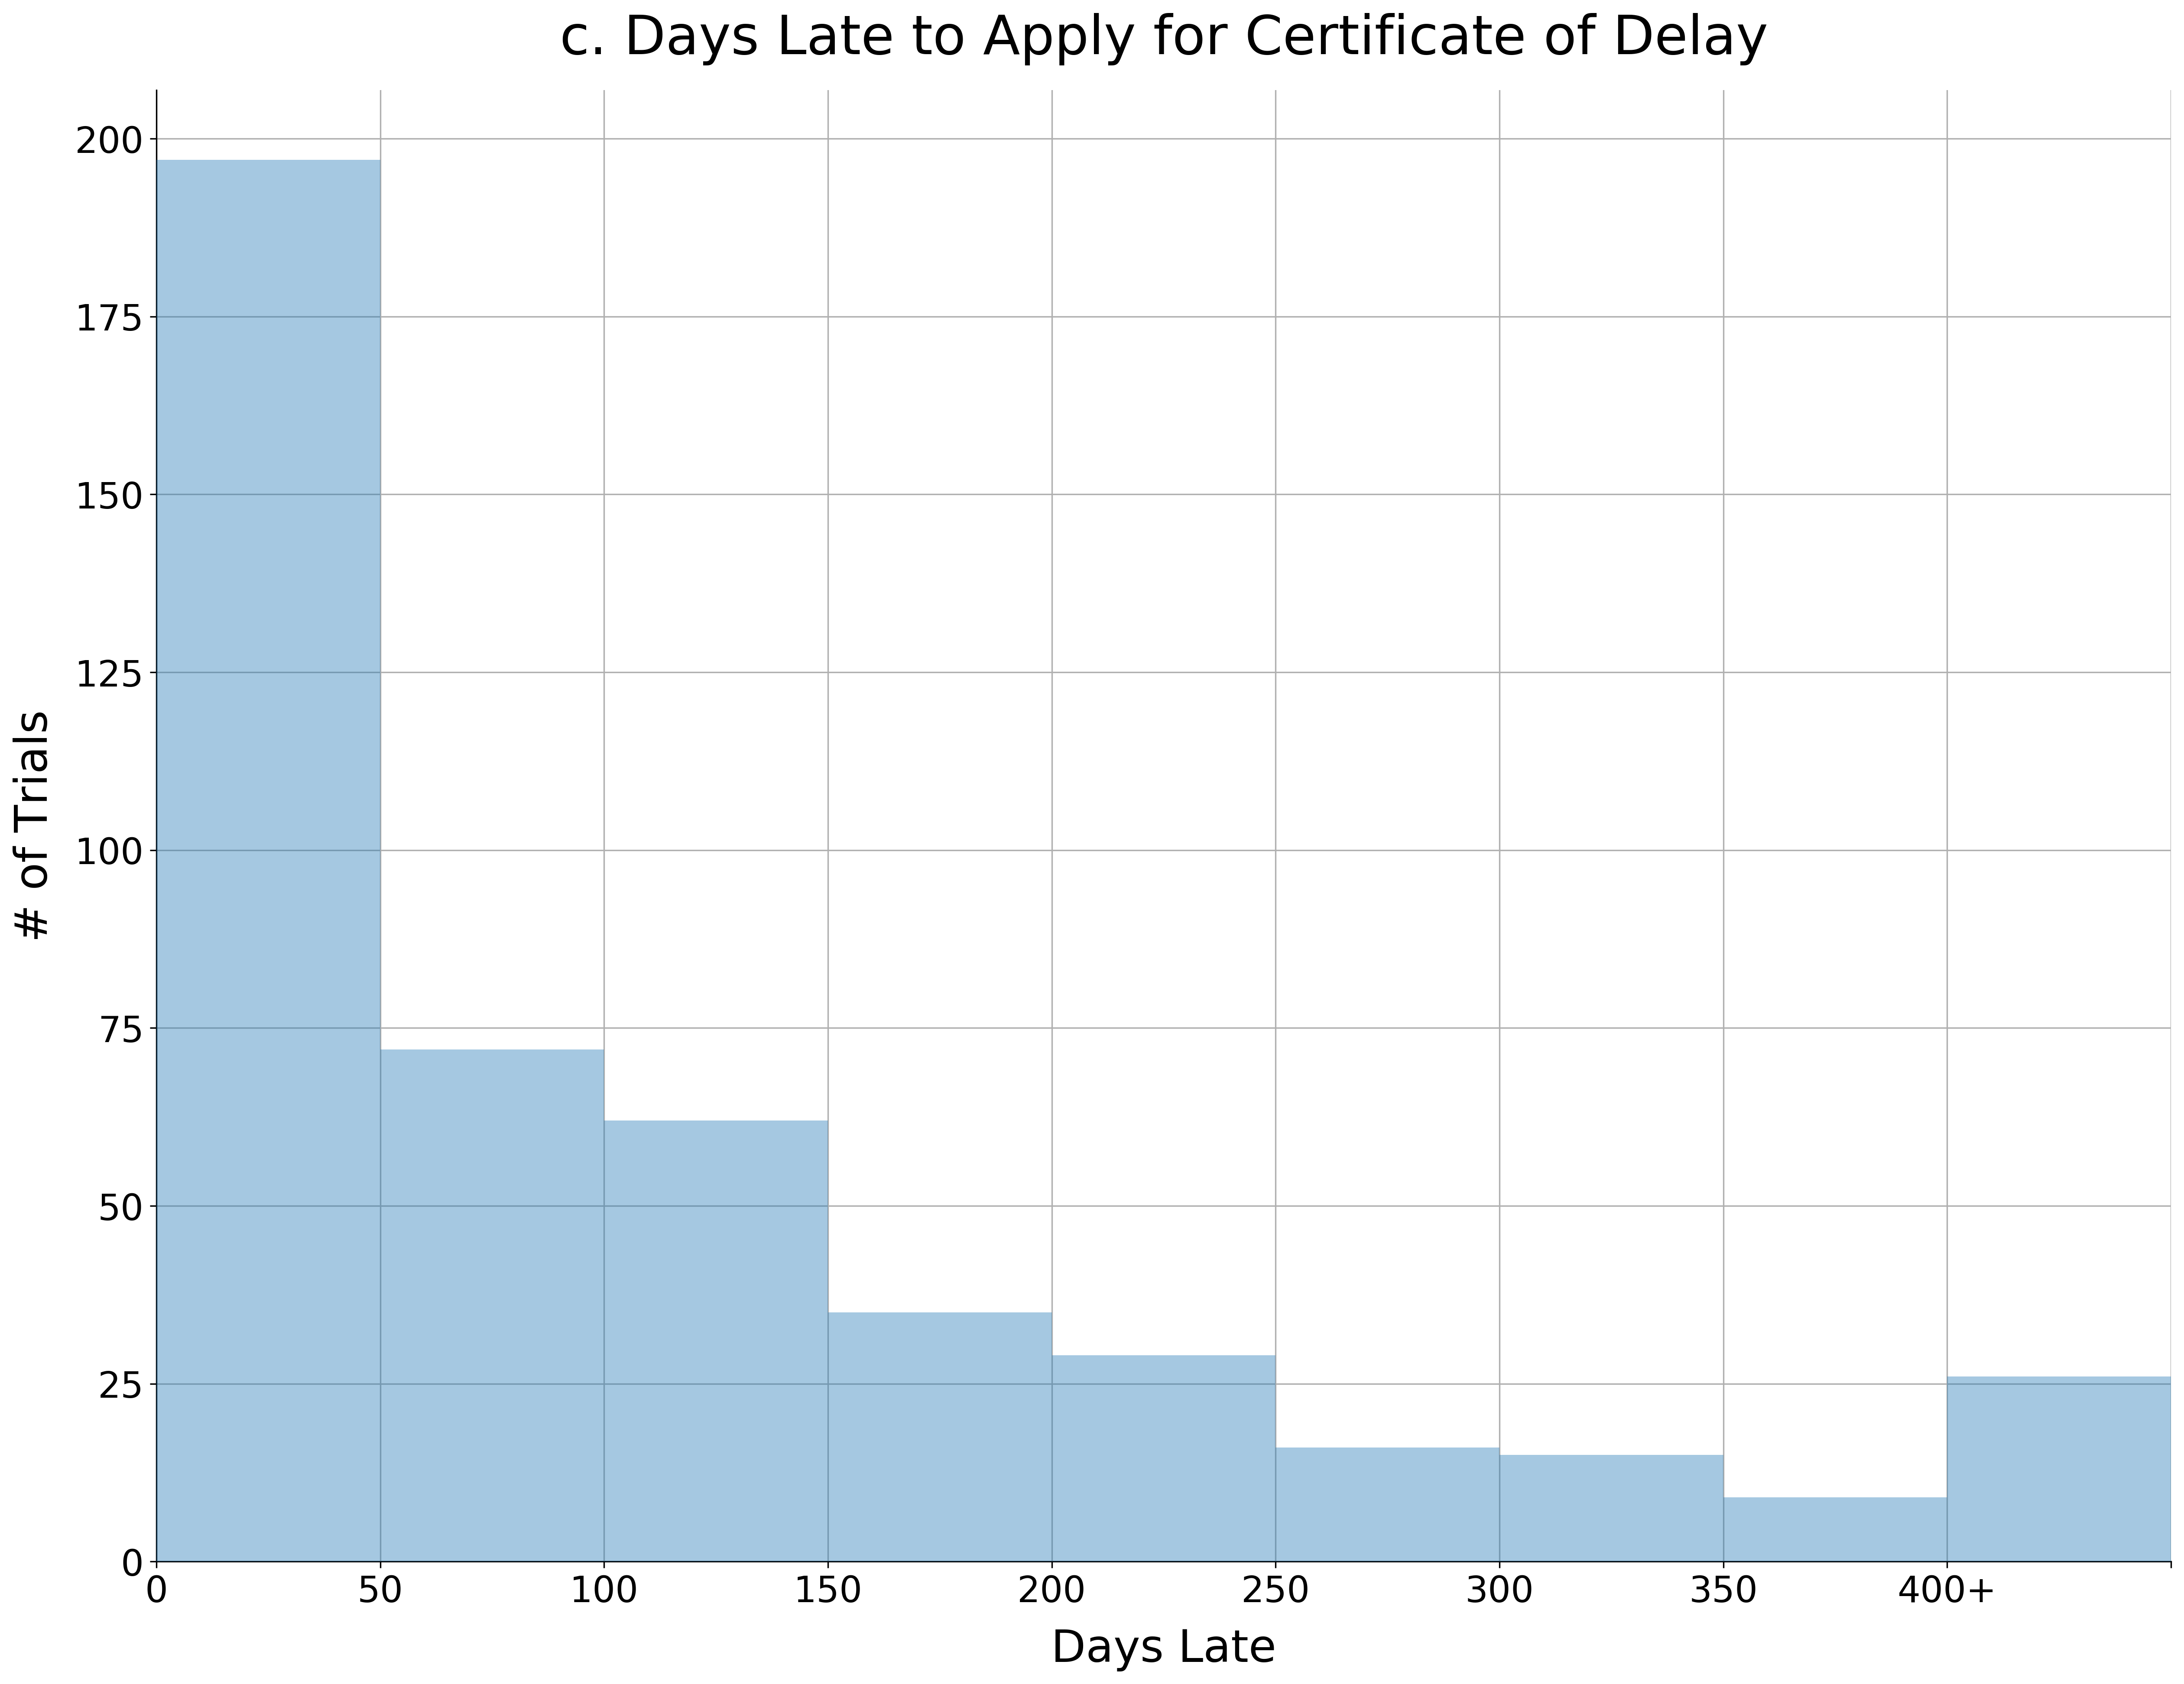

In [46]:
lc_bins = np.arange(0,450 + 1, 50)
xlabels = ['0', '50', '100', '150', '200', '250', '300', '350', '400+']

fig, ax = plt.subplots(figsize=(20, 15), dpi=300)
ax.set_axisbelow(True)
ax.grid(zorder=0)
sns.distplot(np.clip(days_late_count,0,400), hist=True, kde=False, bins=lc_bins, ax=ax,
             hist_kws = {'zorder':10}).set(xlim=(0,450))
ax.set_xticklabels(xlabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('# of Trials', fontsize=25, labelpad=10)
plt.xlabel('Days Late', fontsize=25, labelpad=10)
plt.title("c. Days Late to Apply for Certificate of Delay", pad = 20, fontsize = 30)
plt.show()
#plt.savefig('figures/late_certificate_1c.svg')

In [47]:
#Can crosstab any variable here
crosstab(certificate, 'on_time_cert', 'act_flag')

on_time_cert,0,1,All
act_flag,,,
0,265,505,770
1,196,388,584
All,461,893,1354


In [48]:
#For Table 1
summary = {}

for a in analysis_cols:
    cross = crosstab(certificate, 'on_time_cert', a)
    summary[a] = get_prcts(cross)
    
pd.DataFrame(summary).T

,total,total_var,prct_total,n_comp,prct_comp
act_flag,1354.0,584.0,43.1,388.0,66.4
ind_spon,1354.0,1204.0,88.9,814.0,67.6
drug_trial,1354.0,1061.0,78.4,713.0,67.2
early_phase,1354.0,649.0,47.9,418.0,64.4
late_phase,1354.0,510.0,37.7,357.0,70.0
N/A,1354.0,195.0,14.4,118.0,60.5
quartile_1,1354.0,315.0,23.3,162.0,51.4
quartile_2,1354.0,613.0,45.3,374.0,61.0
quartile_3,1354.0,196.0,14.5,157.0,80.1
quartile_4,1354.0,230.0,17.0,200.0,87.0


In [49]:
x_cert = certificate[['act_flag', 'ind_spon', 'drug_trial', 'late_phase', 'N/A', 'quartile_2', 'quartile_3', 
                      'quartile_4']].reset_index(drop=True)
y_cert = certificate['on_time_cert'].reset_index(drop=True)

In [50]:
#Use this cell to check crude regression analysis of interest:

crude_x = certificate[['quartile_2', 'quartile_3', 'quartile_4']].reset_index(drop=True)

simple_logistic_regression(y_cert,crude_x,cis=.001)

Optimization terminated successfully.
         Current function value: 0.601908
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           on_time_cert   No. Observations:                 1354
Model:                          Logit   Df Residuals:                     1350
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                 0.06150
Time:                        22:09:12   Log-Likelihood:                -814.98
converged:                       True   LL-Null:                       -868.39
Covariance Type:            nonrobust   LLR p-value:                 5.346e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
quartile_2     0.3906      0.140      2.793      0.005       0.116       0.665
quartile_3     1.3355      0.

,OR,0.05%,99.95%,p_value
quartile_2,1.48,0.93,2.34,0.00523
quartile_3,3.80,1.90,7.62,0.00000
quartile_4,6.30,2.99,13.24,0.00000
cons,1.06,0.73,1.53,0.61214


In [51]:
#Outcome here is having an on-time certificate

simple_logistic_regression(y_cert,x_cert, cis=.001)

Optimization terminated successfully.
         Current function value: 0.579821
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           on_time_cert   No. Observations:                 1354
Model:                          Logit   Df Residuals:                     1345
Method:                           MLE   Df Model:                            8
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                 0.09593
Time:                        22:09:12   Log-Likelihood:                -785.08
converged:                       True   LL-Null:                       -868.39
Covariance Type:            nonrobust   LLR p-value:                 6.599e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
act_flag       0.1582      0.124      1.275      0.202      -0.085       0.401
ind_spon       1.5506      0.

,OR,0.05%,99.95%,p_value
act_flag,1.17,0.78,1.76,0.20214
ind_spon,4.71,2.19,10.15,0.00000
drug_trial,1.08,0.60,1.94,0.66596
late_phase,1.14,0.73,1.79,0.32204
N/A,0.97,0.47,2.00,0.89582
quartile_2,1.42,0.89,2.28,0.01373
quartile_3,6.07,2.77,13.32,0.00000
quartile_4,10.58,4.53,24.70,0.00000
cons,0.21,0.07,0.56,0.00000


In [52]:
cert_rank = create_ranking(certificate, 'late_cert')
#c_top_10_prct = cert_rank.late_cert.quantile(.95)
cert_rank_merge = cert_rank.merge(covered_trials, on='sponsor')
cert_rank_merge['prct'] = round((cert_rank_merge['late_cert'] / cert_rank_merge['covered_trials']) * 100,2)
cert_rank_merge[cert_rank_merge.covered_trials >= 50].sort_values(by='prct', ascending=False).reset_index(drop=True).head(11)

,sponsor,late_cert,covered_trials,prct
0,Virginia Commonwealth University,4,57,7.02
1,Vertex Pharmaceuticals Incorporated,3,55,5.45
2,"University of California, San Francisco",6,219,2.74
3,Sanofi,3,112,2.68
4,Columbia University,3,112,2.68
5,Incyte Corporation,2,82,2.44
6,"The University of Texas Health Science Center,...",3,141,2.13
7,Eli Lilly and Company,4,192,2.08
8,University of Michigan Rogel Cancer Center,1,50,2.00
9,University of Alabama at Birmingham,3,158,1.90


In [148]:
only_cert = certificate[['sponsor', 'late_cert']].groupby('sponsor', as_index=False)['late_cert'].agg(['sum','count'])
only_cert['prct'] = round((only_cert['sum'] / only_cert['count']) * 100,2)
merged_cert = only_cert.merge(covered_trials, on='sponsor')
merged_cert[merged_cert.covered_trials >= 50].sort_values(by='prct', ascending=False).head(11)

,sponsor,sum,count,prct,covered_trials
466,University of Washington,1,1,100.00,145
107,Cedars-Sinai Medical Center,1,1,100.00,60
458,"University of Maryland, Baltimore",1,1,100.00,80
145,Duke University,3,3,100.00,179
471,Vanderbilt University Medical Center,1,1,100.00,90
451,University of Alabama at Birmingham,3,3,100.00,158
122,Columbia University,3,4,75.00,112
481,Virginia Commonwealth University,4,6,66.67,57
455,"University of California, San Francisco",6,10,60.00,219
174,Fred Hutchinson Cancer Research Center,1,2,50.00,72


In [154]:
merged_cert[(merged_cert.covered_trials >= 50) & (merged_cert['count'] >= 5)].sort_values(by='prct', ascending=False).head(15)

,sponsor,sum,count,prct,covered_trials
481,Virginia Commonwealth University,4,6,66.67,57
455,"University of California, San Francisco",6,10,60.00,219
381,Sanofi,3,9,33.33,112
425,"The University of Texas Health Science Center,...",3,10,30.00,141
211,Incyte Corporation,2,7,28.57,82
479,Vertex Pharmaceuticals Incorporated,3,12,25.00,55
461,University of Michigan,2,8,25.00,111
157,Emory University,2,9,22.22,196
108,Celgene,1,5,20.00,82
470,VA Office of Research and Development,1,5,20.00,169


# Document Analysis

The Final Rule stipulates that a protocol and statistical analysis plan for covered trials are required to be reported alongside results for trials covered under the FDAAA 2007.

In [53]:
doc_df = df[['nct_id', 'results_due', 'has_results', 'pending_results', 'has_certificate','results_first_submitted_date', 
             'results_first_posted_date','primary_completion_date', 'due_date', 'last_updated_date', 'documents', 'sponsor',
             'act_flag','ind_spon', 'drug_trial', 'phase_var', 'early_phase', 'late_phase', 'N/A', 'quartile_1', 
             'quartile_2', 'quartile_3', 'quartile_4']].reset_index(drop=True)

doc_df['has_documents'] = np.where(doc_df.documents.notnull(), 1,0)
doc_df['results_first_submitted_date'] = pd.to_datetime(doc_df['results_first_submitted_date'])
doc_df['primary_completion_date'] = pd.to_datetime(doc_df['primary_completion_date'])
doc_df['due_date'] = pd.to_datetime(doc_df['due_date'])
doc_df['last_updated_date'] = pd.to_datetime(doc_df['last_updated_date'])
doc_df['results_first_posted_date'] = pd.to_datetime(doc_df['results_first_posted_date'])

In [54]:
#Describing the population

due_and_docs = len(doc_df[(doc_df.results_due == 1) & (doc_df.has_documents == 1)])
due_docs_reported = len(doc_df[(doc_df.results_due == 1) & (doc_df.has_documents == 1) & (doc_df.has_results == 1)])
results_no_docs = len(doc_df[(doc_df.results_due == 1) & (doc_df.has_documents == 0) & (doc_df.has_results == 1)])
no_results_docs = len(doc_df[(doc_df.results_due == 1) & (doc_df.has_documents == 1) & (doc_df.has_results == 0) ])
check = len(doc_df[(doc_df.results_due == 1) & (doc_df.has_documents == 0) & (doc_df.has_results == 0) & (doc_df.pending_results==1)])
results_due = doc_df.results_due.sum()
print('{} Trials are due to report results, and therefore should have uploaded a protocol and SAP'.format(results_due))
print('Of these {} due trials have any documents, {} due trials have both documents and results'.format(due_and_docs,due_docs_reported))
print('{} due trials have documents but no results, {} have no documents but results'.format(no_results_docs, results_no_docs))
check

8863 Trials are due to report results, and therefore should have uploaded a protocol and SAP
Of these 5528 due trials have any documents, 5401 due trials have both documents and results
127 due trials have documents but no results, 48 have no documents but results


622

In [55]:
has_docs_df = doc_df[['nct_id', 'documents']][doc_df.has_documents == 1].reset_index(drop=True)

has_docs_ids = has_docs_df.nct_id.to_list()

In [56]:
#this makes each document it's own row with nct_id as the index
dfs_list = []

import ast
has_docs = has_docs_df.copy()
has_docs['documents'] = has_docs['documents'].apply(ast.literal_eval)
for index, row in has_docs.iterrows():
    if isinstance(has_docs['documents'][index], list):
        l = len(has_docs['documents'][index])
        ix = [has_docs['nct_id'][index]] * l
        interim_df = pd.DataFrame(has_docs['documents'][index], index = ix)
        dfs_list.append(interim_df)
    else:
        interim_df = pd.DataFrame(has_docs['documents'][index], index = [has_docs['nct_id'][index]])
        dfs_list.append(interim_df)

In [57]:
#Further processing
nct_index_df = pd.concat(dfs_list, sort=True)
nct_index_df = nct_index_df.reset_index(level=0)
nct_index_df.rename(columns= {nct_index_df.columns[0]: "nct_id"}, inplace=True)

#fixing incorrect data points that came up in summary review of data
#(verfified in document https://clinicaltrials.gov/ProvidedDocs/10/NCT01866410/Prot_SAP_000.pdf)
#(and in document https://clinicaltrials.gov/ProvidedDocs/42/NCT03241342/Prot_SAP_000.pdf)
bad_index = nct_index_df.index[nct_index_df['document_date'] == 'January 24, 1014'].tolist()[0]
nct_index_df.at[bad_index,'document_date'] = 'January 24, 2014'
bad_index = nct_index_df.index[nct_index_df['document_date'] == 'April 10, 1018'].tolist()[0]
nct_index_df.at[bad_index,'document_date'] = 'April 10, 2018'

nct_index_df['document_date'] = pd.to_datetime(nct_index_df['document_date'])

In [58]:
#The first time you run this notebook on a new dataset, you can get the data on when the documents 
#were last updated by importing and running the "history_scrape" function. However, if you are using 
#the shared data from the project or re-running a prior analysis you can just export and save a CSV that 
#you can then re-load.

#If you already have the output from the above exported to CSV, just run this cell pointing to that file
#if it isn't already in the same directory (this will work assuming no changed to the cloned repo)

try:
    docs_updates = pd.read_csv(parent + '/data/history_scrape_2021-01-18.csv')
except FileNotFoundError:
    from lib.trial_history import history_scrape
    most_recent_doc_update = history_scrape(tqdm(has_docs_ids[820:]), date(2021,1,18))
    docs_updates = pd.DataFrame(most_recent_doc_update)
    docs_updates.to_csv('history_scrape_{}.csv'.format(date(2021,1,18)))

In [59]:
#Cleaning and managing the scraped data as above
bad_index = docs_updates.index[docs_updates['document_date'] == 'January 24, 1014'].tolist()[0]
docs_updates.at[bad_index,'document_date'] = 'January 24, 2014'
bad_index = docs_updates.index[docs_updates['document_date'] == 'April 10, 1018'].tolist()[0]
docs_updates.at[bad_index,'document_date'] = 'April 10, 2018'
docs_updates['upload_date'] = pd.to_datetime(docs_updates['upload_date'])
docs_updates['document_date'] = pd.to_datetime(docs_updates['document_date'])
docs_updates['version_date'] = pd.to_datetime(docs_updates['version_date'])
docs_updates.head()

,Unnamed: 0,nct_id,version_date,document_type,document_date,upload_date,no_sap
0,0,NCT00200161,2018-03-05,Study Protocol and Statistical Analysis Plan,2011-11-08,2018-01-10 14:58:00,NaN
1,1,NCT00345865,2020-07-10,Study Protocol and Statistical Analysis Plan,2014-01-16,2020-06-24 11:20:00,NaN
2,2,NCT00352794,2019-07-18,Study Protocol and Statistical Analysis Plan,2014-01-14,2019-04-19 11:08:00,NaN
3,3,NCT00363649,2018-10-10,Study Protocol and Statistical Analysis Plan,2014-04-25,2018-09-25 11:56:00,NaN
4,4,NCT00450814,2019-11-21,Study Protocol and Statistical Analysis Plan,2017-01-20,2019-07-15 15:09:00,NaN


In [60]:
#For ease of analysis we set dummy dates, for submission dates not scraped, 
#either very far in the past or future. This makes determining the earliest and latest
#submission dates much easier during grouping in the next step
full_docs_df = nct_index_df.merge(docs_updates, on=['nct_id', 'document_date', 'document_type'])
full_docs_df['dummy_date_past'] = pd.to_datetime(-2208988800, unit='s')
full_docs_df['dummy_date_future'] = pd.to_datetime(4102444800, unit='s')

In [61]:
#Getting to 1 line per trial

def f(x):
    d = {}
    d['number_of_documents'] = x.nct_id.count()
    d['num_protocol_docs'] = np.where(x.document_has_protocol == 'Yes',1,0).sum()
    d['num_sap_docs'] = np.where(x.document_has_sap == 'Yes',1,0).sum()
    d['has_protocol'] = np.where(((np.where(x.document_has_protocol == 'Yes',1,0).sum())>0),1,0)
    d['has_sap'] = np.where(((np.where(x.document_has_sap == 'Yes',1,0).sum())>0),1,0)
    d['no_sap'] = np.where((np.where(x.no_sap.notnull(), 1, 0).sum() > 0), 1, 0)
    d['first_protocol_submitted'] = np.where(x.document_has_protocol == 'Yes', x.upload_date,x.dummy_date_future).min()
    d['latest_protocol_submitted'] = np.where(x.document_has_protocol == 'Yes', x.upload_date,x.dummy_date_past).max()
    d['first_sap_submitted'] = np.where(x.document_has_sap == 'Yes', x.upload_date,x.dummy_date_future).min()
    d['latest_sap_submitted'] = np.where(x.document_has_sap == 'Yes', x.upload_date,x.dummy_date_past).max()
    return pd.Series(d)

grouped = full_docs_df.groupby('nct_id').apply(f).reset_index()

#Now we can easily replace those far in the future/past dates with nulls
grouped.loc[grouped['latest_protocol_submitted'] == '1900-01-01', 'latest_protocol_submitted'] = pd.NaT
grouped.loc[grouped['latest_sap_submitted'] == '1900-01-01', 'latest_sap_submitted'] = pd.NaT
grouped.loc[grouped['first_protocol_submitted'] == '2100-01-01', 'first_protocol_submitted'] = pd.NaT
grouped.loc[grouped['first_sap_submitted'] == '2100-01-01', 'first_sap_submitted'] = pd.NaT

In [62]:
#Bringing in additional data we need for further analysis

more_cols = ['nct_id', 'results_due', 'has_results', 'pending_results', 'primary_completion_date', 'due_date', 
             'results_first_submitted_date', 'results_first_posted_date', 'last_updated_date', 'ind_spon', 'drug_trial', 
             'phase_var', 'sponsor', 'act_flag', 'early_phase', 'late_phase', 'N/A', 'quartile_1', 'quartile_2', 'quartile_3', 
             'quartile_4']
merged = doc_df[more_cols].merge(grouped, how='left', on='nct_id')

In [63]:
#Data cleaning
merged.number_of_documents.fillna(0, inplace=True)
merged.num_protocol_docs.fillna(0, inplace=True)
merged.num_sap_docs.fillna(0, inplace=True)
merged.has_protocol.fillna(0, inplace=True)
merged.has_sap.fillna(0, inplace=True)
merged.no_sap.fillna(0, inplace=True)
merged['prot_after_completion'] = np.where(merged.latest_protocol_submitted > merged.primary_completion_date, 1, 0)
merged['sap_after_completion'] = np.where(merged.latest_sap_submitted > merged.primary_completion_date, 1, 0)
merged.head()

,nct_id,results_due,has_results,pending_results,primary_completion_date,due_date,results_first_submitted_date,results_first_posted_date,last_updated_date,ind_spon,...,num_sap_docs,has_protocol,has_sap,no_sap,first_protocol_submitted,latest_protocol_submitted,first_sap_submitted,latest_sap_submitted,prot_after_completion,sap_after_completion
0,NCT00136435,0,0,0,2021-07-31,2022-07-31,NaT,NaT,2020-03-19,0,...,0.0,0,0,0,NaT,NaT,NaT,NaT,0,0
1,NCT00147056,0,0,0,2022-12-31,2023-12-31,NaT,NaT,2020-03-09,1,...,0.0,0,0,0,NaT,NaT,NaT,NaT,0,0
2,NCT00200161,1,1,0,2017-05-04,2018-05-04,2018-01-10,2018-03-07,2018-03-05,0,...,1.0,1,1,0,2018-01-10 14:58:00,2018-01-10 14:58:00,2018-01-10 14:58:00,2018-01-10 14:58:00,1,1
3,NCT00262470,0,0,0,2022-12-31,2023-12-31,NaT,NaT,2020-08-30,0,...,0.0,0,0,0,NaT,NaT,NaT,NaT,0,0
4,NCT00306098,0,0,0,2021-05-31,2022-05-31,NaT,NaT,2020-07-23,0,...,0.0,0,0,0,NaT,NaT,NaT,NaT,0,0


In [64]:
#filters

due_reported_filt = ((merged.results_due == 1) & (merged.has_results == 1))

due_unreported_filt = (merged.results_due == 1) & (merged.has_results == 0)

In [65]:
#Building various counts to describe the population below

#The number due to report results
all_due = len(merged[(merged.results_due == 1)])

#The number of these that have results
due_results = len(merged[due_reported_filt])

#Pending results should have results eventually (but we can't assess right now)
pending = len(merged[due_unreported_filt & (merged.pending_results == 1)])

#Due, results fully available, and has a protocol and a SAP
prot_and_sap = len(merged[due_reported_filt & (merged.has_protocol == 1) & (merged.has_sap == 1)])

#Due, results fully available, and has a protocol, a SAP, or a proactive statement that no SAP exists
prot_sap_or_no_sap_stmt = len(merged[due_reported_filt & (merged.has_protocol == 1) 
                                     & ((merged.has_sap == 1) | (merged.no_sap == 1))])

#Due, results, prot, sap unaccounted
prot_unaccounted_sap = len(merged[due_reported_filt & (merged.has_protocol == 1) 
                                     & ((merged.has_sap == 0) & (merged.no_sap == 0))])

#Due, results, sap accounted, no prot
sap_unaccounted_prot = len(merged[due_reported_filt & (merged.has_protocol == 0) 
                                     & ((merged.has_sap == 1) | (merged.no_sap == 1))])


#total due and unreported
due_unreported = len(merged[due_unreported_filt])

#No results, but has some form of documents available/accounted for
unreported_any_docs = len(merged[due_unreported_filt & ((merged.has_protocol == 1) | ((merged.has_sap == 1) | (merged.no_sap == 1)))])

In [66]:
print(f'''There are {due_results} trials that are due to report and have subsequently completed clinicaltrials.gov \
quality control meaning results are fully posted. Of these, \
{prot_and_sap} ({round((prot_and_sap/due_results) * 100, 2)}%) have their protocol and sap included in their record. \
An additional {prot_sap_or_no_sap_stmt-prot_and_sap} trials have proactively declared they have no SAP meaning \
{prot_sap_or_no_sap_stmt} ({round((prot_sap_or_no_sap_stmt/due_results) * 100, 2)}%) have all documents and results \
fully accounted for. \
Among trials without results, {unreported_any_docs} ({round((unreported_any_docs/due_unreported)* 100, 2)}%) have \
any form of documentation available. \
''')

There are 5449 trials that are due to report and have subsequently completed clinicaltrials.gov quality control meaning results are fully posted. Of these, 5320 (97.63%) have their protocol and sap included in their record. An additional 81 trials have proactively declared they have no SAP meaning 5401 (99.12%) have all documents and results fully accounted for. Among trials without results, 107 (3.13%) have any form of documentation available. 


In [67]:
just_due_results = merged[(merged.has_results == 1) & (merged.results_due == 1)].reset_index(drop=True)

just_due_results['docs_accounted'] = np.where((just_due_results.has_protocol == 1) & 
                                              ((just_due_results.has_sap == 1) | 
                                               (just_due_results.no_sap == 1)),1,0)

In [68]:
crosstab(just_due_results, 'docs_accounted', 'act_flag')

docs_accounted,0,1,All
act_flag,,,
0,48,3764,3812
1,0,1637,1637
All,48,5401,5449


In [69]:
#For Table 1
summary = {}

for a in analysis_cols:
    cross = crosstab(just_due_results, 'docs_accounted', a)
    summary[a] = get_prcts(cross)
    
pd.DataFrame(summary).T

,total,total_var,prct_total,n_comp,prct_comp
act_flag,5449.0,1637.0,30.0,1637.0,100.0
ind_spon,5449.0,2522.0,46.3,2509.0,99.5
drug_trial,5449.0,4008.0,73.6,3969.0,99.0
early_phase,5449.0,2276.0,41.8,2254.0,99.0
late_phase,5449.0,1266.0,23.2,1257.0,99.3
N/A,5449.0,1907.0,35.0,1890.0,99.1
quartile_1,5449.0,830.0,15.2,821.0,98.9
quartile_2,5449.0,1278.0,23.5,1268.0,99.2
quartile_3,5449.0,1577.0,28.9,1563.0,99.1
quartile_4,5449.0,1764.0,32.4,1749.0,99.1


In [70]:
#The regression doesn't converge with 'act_flag' included as it is perfectly predictive, so this is removed
x_docs = just_due_results[['ind_spon', 'drug_trial', 'late_phase', 'N/A', 'quartile_2', 
                           'quartile_3', 'quartile_4']].reset_index(drop=True)
y_docs = just_due_results.docs_accounted.reset_index(drop=True)

In [71]:
#Use this cell to check crude regression analysis of interest:

crude_x = just_due_results[['quartile_2', 'quartile_3', 'quartile_4']].reset_index(drop=True)

simple_logistic_regression(y_docs,crude_x,cis=.001)

Optimization terminated successfully.
         Current function value: 0.050405
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:         docs_accounted   No. Observations:                 5449
Model:                          Logit   Df Residuals:                     5445
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:               0.0009707
Time:                        22:09:51   Log-Likelihood:                -274.66
converged:                       True   LL-Null:                       -274.92
Covariance Type:            nonrobust   LLR p-value:                    0.9114
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
quartile_2     0.3293      0.462      0.713      0.476      -0.575       1.234
quartile_3     0.2020      0.

,OR,0.05%,99.95%,p_value
quartile_2,1.39,0.30,6.35,0.47563
quartile_3,1.22,0.30,5.03,0.63805
quartile_4,1.28,0.32,5.15,0.56243
cons,91.22,30.28,274.83,0.00000


In [72]:
#Adjusted regression

simple_logistic_regression(y_docs,x_docs, cis=.001)

Optimization terminated successfully.
         Current function value: 0.049497
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:         docs_accounted   No. Observations:                 5449
Model:                          Logit   Df Residuals:                     5441
Method:                           MLE   Df Model:                            7
Date:                Fri, 10 Sep 2021   Pseudo R-squ.:                 0.01896
Time:                        22:09:51   Log-Likelihood:                -269.71
converged:                       True   LL-Null:                       -274.92
Covariance Type:            nonrobust   LLR p-value:                    0.1658
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ind_spon       0.9324      0.368      2.531      0.011       0.210       1.654
drug_trial    -0.4777      0.

,OR,0.05%,99.95%,p_value
ind_spon,2.54,0.76,8.54,0.01137
drug_trial,0.62,0.16,2.44,0.25148
late_phase,0.96,0.24,3.83,0.92281
N/A,0.95,0.29,3.09,0.87625
quartile_2,1.19,0.26,5.57,0.70724
quartile_3,1.57,0.37,6.58,0.30130
quartile_4,1.58,0.39,6.44,0.28678
cons,87.03,14.77,512.66,0.00000


In [73]:
docs_rank = create_ranking(just_due_results, 'docs_accounted', marker = 0)
docs_rank_merge = docs_rank.merge(covered_trials, on='sponsor')
docs_rank_merge['prct'] = round((docs_rank_merge['docs_accounted'] / docs_rank_merge['covered_trials']) * 100,2)
docs_rank_merge[docs_rank_merge.covered_trials >= 50].sort_values(by='prct', ascending=False).head(12)

,sponsor,docs_accounted,covered_trials,prct
33,Milton S. Hershey Medical Center,1,51,1.96
19,University of Utah,1,65,1.54
15,New York State Psychiatric Institute,1,79,1.27
5,"University of Wisconsin, Madison",1,94,1.06
1,Massachusetts General Hospital,3,303,0.99
37,Icahn School of Medicine at Mount Sinai,1,101,0.99
3,"University of California, San Francisco",2,219,0.91
9,Weill Medical College of Cornell University,1,111,0.90
31,Columbia University,1,112,0.89
16,University of Minnesota,1,114,0.88


In [83]:
due_results_spon = df[(df.results_due == 1) & (df.has_results == 1)][['sponsor', 'results_due', 'has_results']].groupby('sponsor', as_index=False).sum()

In [162]:
just_due_spon = docs_rank_merge.merge(due_results_spon, how='left', on='sponsor')
just_due_spon['new_prct'] = round((just_due_spon['docs_accounted'] / just_due_spon['results_due']) * 100,2)
just_due_spon[just_due_spon.covered_trials >= 50].sort_values(by='new_prct', ascending=False).head(14)

,sponsor,docs_accounted,covered_trials,prct,results_due,has_results,new_prct
33,Milton S. Hershey Medical Center,1,51,1.96,15,15,6.67
19,University of Utah,1,65,1.54,17,17,5.88
9,Weill Medical College of Cornell University,1,111,0.90,18,18,5.56
5,"University of Wisconsin, Madison",1,94,1.06,19,19,5.26
16,University of Minnesota,1,114,0.88,25,25,4.00
3,"University of California, San Francisco",2,219,0.91,50,50,4.00
24,Dana-Farber Cancer Institute,1,197,0.51,26,26,3.85
15,New York State Psychiatric Institute,1,79,1.27,27,27,3.70
1,Massachusetts General Hospital,3,303,0.99,81,81,3.70
31,Columbia University,1,112,0.89,27,27,3.70
